# Convention theory and goal of experiments
Convention theory is based on the idea that actors have different motivations for their actions but have to find some sort of common ground in order to enable economic or social transactions. The solution lies in bringing together justifications from different worlds into a formal or information convention, a negotiated agreement that structures the desired transaction. Actors work together to come to a compromise about the convention to use.
(https://www.academia.edu/2745478/Building_Quality_Building_Green_Conventions_Theory_and_Industry_Transformation)

These used conventions can simultaneously satisfy multiple justifications.


Our goal is to build a model to provide statistical estimates of the existince of the various conventions in the data to be analyzed, rather than to make automatic decisions. 


Calibration vs Discrimination(ROC/AUC measurements):
http://queirozf.com/entries/introduction-to-auc-and-calibrated-models-with-examples-using-scikit-learn




In [ ]:
To Do:
    -store the keywords to git for the audit tool
    - finish the SS analysis
    -

In [170]:
%run "All_helper_classes.ipynb" sort=False

#from "Models training helpers.ipynb" we will import 3 helper classes and the associated helper methods.
parsing_helpers = generic_parsing_helpers()
aivm_helper = AIVM_helper()
model_helpers, info = default_model_helpers_for_project()
#if you want to see the paths now can call with...
display (HTML(info))

paths = project_paths()

#same for paths and repo data, display using...
display (HTML(paths.get_paths_data()))
display (HTML(paths.get_repo_data()))

# #We could move these imports to the helper classes file
# import matplotlib.lines as mlines
# import matplotlib.transforms as mtransforms
# from sklearn.calibration import calibration_curve
# from sklearn.calibration import CalibratedClassifierCV
# from sklearn.isotonic import IsotonicRegression


Necessary libraries imported.
Initialised generic_parsing_helpers class and methods
Initialised AIVM_helper class and methods
Initialised model_helpers class and methods


In [171]:
!pip install dill --user


You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
def save_session(name):                   
    filename = name +'.pkl'
    dill.dump_session(filename)
    
def retrieve_saved_session(name):
    # and to load the session again:
    filename = name +'.pkl'
    dill.load_session(filename)

In [7]:
%%javascript
//To remove scroll from any output area and automatically extend the jupyter cell
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Global Variables

In [8]:
USE_GIT_HUB = False

_DLModelsIsotonicRegression = {}
_DLModels = {}
_DLData_val_x_txt_seq = {}
_DLData_val_x_txt = {}
_DLData_val_y = {}
training_df = pd.DataFrame()

gathered_conventions_files = {} 
gathered_conventions_df = pd.DataFrame()

#holds the valadation data for models with 1 and 0 values (is part of, is not part of )
validation_data_from_models = pd.DataFrame()

#holds the valadation data once it is aggrigated and only the 1 samples remain (is part of)
validation_data_pos_from_models = pd.DataFrame()

metrics_for_all = pd.DataFrame()

global_final_threshold = {}
global_final_results_df = pd.DataFrame()

thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Read the Training data and also the gathered data(to generate vocab for word embedding)

https://raw.githubusercontent.com/aideenf/AIVC/master/cp_wssc/Data/Iterative-models-building/Training%20data/Conventions/training_ALL.tsv
Data/Iterative-models-building/Training data/Conventions/training_ALL.tsv
Initialised generic_parsing_helpers class and methods


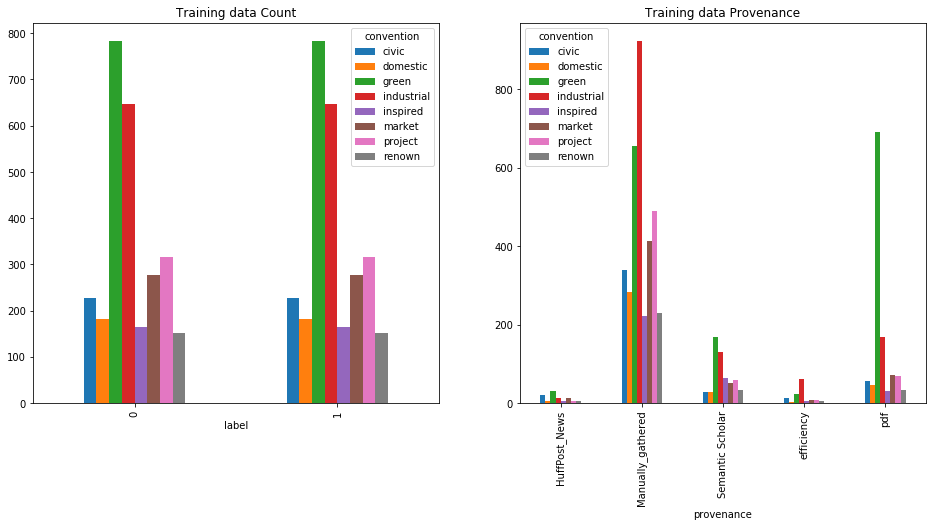

<Figure size 432x288 with 0 Axes>

In [9]:
#Read the combined original training data and audited data file from "training_ALL.tsv"
#Note this method already calls "remove_line_breaks"


print (paths.TRAINING_DATA_ALL_DIR_FILE_GIT)
print (paths.TRAINING_DATA_ALL_DIR_FILE_LOCAL)

#Note this method already calls "remove_line_breaks"
training_df = model_helpers.get_training_data(
                            USE_GIT_HUB,
                            paths.TRAINING_DATA_ALL_DIR_FILE_GIT,
                            paths.TRAINING_DATA_ALL_DIR_FILE_LOCAL, 
                            paths.GIT_OWNER,
                            paths.GIT_REPO)


def display_training_data(training_df):
    training_df['text'] = training_df['text'].str.strip()
    training_df['text'] = training_df['text'].apply(aivm_helper.pre_process_sentence)
    training_df.head(5)
    display(HTML("Training Data Analysis, number of sentences per convention and per provenance"))
    count1 = widgets.HTML(value=pd.DataFrame(training_df.groupby('convention')['text'].count()).to_html())
    count2 = widgets.HTML(value=pd.DataFrame(training_df.groupby('provenance')['text'].count() ).to_html())
    display (widgets.HBox([count1, count2]))

    counts_cross_tab = pd.crosstab(training_df['label'],training_df['convention'])
    provenance_cross_tab = pd.crosstab(training_df['provenance'],training_df['convention'])

    fig = plt.figure(figsize=(16,7))
    axes1 = plt.subplot(1,2,1)
    axes2 = plt.subplot(1,2,2)
    counts_cross_tab.plot(ax = axes1, kind='bar', title ="Training data Count")
    provenance_cross_tab.plot(ax = axes2, kind='bar', title ="Training data Provenance")
    plt.show()
    _ = plt.close(fig)
    _ = plt.clf()

    count1 = 0
    count2 = 0
    provenance_cross_tab = pd.DataFrame()
    gc.collect()
    
display_training_data(training_df)

Initialised AIVM_helper class and methods


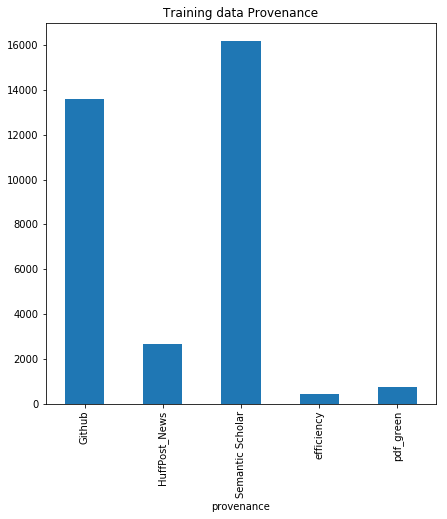

Total number of sentences: 33632


<Figure size 432x288 with 0 Axes>

In [10]:
#Note this method already processes the gathered data and reads either from local or directly from git.
gathered_conventions_files, gathered_conventions_df = model_helpers.get_aggregated_gathered_data (
                            USE_GIT_HUB,
                            paths.GATHERED_DATA_CONV_DIR_GIT,
                            paths.GATHERED_DATA_CONV_DIR_LOCAL,
                            paths.GITHUB_GATHERED_URL_PATH, 
                            paths.GIT_OWNER,
                            paths.GIT_REPO)

def display_gathered_data(gathered_conventions_df):
    gathered_conventions_df['text'] = gathered_conventions_df['text'].str.strip()
    gathered_conventions_df['text'] = gathered_conventions_df['text'].apply(aivm_helper.pre_process_sentence)
    display(HTML("Gathered data"))
    count = widgets.HTML(value=pd.DataFrame(gathered_conventions_df.groupby('provenance')['text'].count() ).to_html())
    display (widgets.HBox([count]))

    fig = plt.figure(figsize=(8,8))
    gathered_conventions_df.groupby('provenance')['text'].count().plot(kind='bar', figsize=(7,7), title ="Training data Provenance")
    plt.show()
    _ = plt.close(fig)
    _ = plt.clf()
    count = 0
    print ("Total number of sentences:",gathered_conventions_df.shape[0] )

display_gathered_data(gathered_conventions_df)

# Get a list of keywords per convention from the Training data

In [164]:
all_words, top_5 = model_helpers.get_keyword_list(training_df, 0.05, 30, show=False)
display(top_5)
all_words = 0
gc.collect()

/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['articl', 'research'] not in stop_words.



,Convention,Keywords
0,Civic,"Community, Collective, Civic, Interests, Chapter"
1,Domestic,"Superiors, Upbringing, Household, Children, Habit"
2,Green,"Green, Economy, Growth, Development, Carbon"
3,Industrial,"Performance, Standard, Reliable, Tests, Control"
4,Inspired,"Inspiration, Inspired, Creative, Unconscious, ..."
5,Market,"Business, Customized, Goods, Buy, Competition"
6,Project,"City, Projective, Links, Connections, Projects"
7,Renown,"Opinion, Press, Fame, Audience, Message"


27551

# Train the DL Models
A multi-label classifier assigns a set of labels to each sentence. The simplest multi-label classifier, called Binary Relevance (BR), applies one binary classifier to each label(convention) independently and takes the product of the individual label probabilities as the overall label-set probability (confidence). Despite its many known drawbacks, such as generating suboptimal predictions and poorly calibrated confidence scores, BR is widely used in practice due to its speed and simplicity.[ Tsoumakas, G., Katakis, I.: Multi-label classification: An overview. Int J Data Warehousing and Mining 2007, 1–13 (2007)]

As this problem is multi-label and multi class the overall solution is a one v's all, Binary Relevance approach.

In [12]:
## Train DL models
## Vocabulary loading
def _read_glove_embeddings(glove_dir, embedding_dim):
    print ("Reading word embedding from:", os.path.join(glove_dir, 'glove.6B.{}d.txt'.format(embedding_dim)))
    ## Reading GLOVE (precalculated word embeddings)
    embeddings_index = {}
    f = open(os.path.join(glove_dir, 'glove.6B.{}d.txt'.format(embedding_dim)))
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    return embeddings_index



def train_models(gathered_conventions_df, training_df):
    """
    N=1
    models = []
    for i in range(N):
        result = model_helpers.train_DL_models(training_df,
                    data_class_column="convention", 
                    data_label_column="label",
                    tokenizer=extended_tokenizer,
                    random_seed=0,
                    use_validation=True) 
        models.append(result)
    
    """
    embeddings_index =_read_glove_embeddings(glove_dir=paths.GLOVE_DIR_LOCAL, embedding_dim=model_helpers.EMBEDDING_DIM)
    print ("Embeddings:", type(embeddings_index))
    column_to_tokenize = 'text'
    gathered_and_training = pd.DataFrame(gathered_conventions_df[column_to_tokenize].append(training_df[column_to_tokenize]))##Adding training data sentences
    extended_tokenizer = parsing_helpers.create_tokenizer(gathered_and_training, 
                                                            column_to_tokenize,
                                                          max_words=model_helpers.MAX_NB_WORDS)
    
    #we do not need the tokenizer for some time so we will store it to pickle
    #now we use same tokenizer for all models so just storing one, we could store all.
    with open(os.path.join("extended_tokenizer.obj", ), 'wb') as f:
        # Pickle the tokenizer using the highest protocol available.
        pickle.dump(extended_tokenizer, f, pickle.HIGHEST_PROTOCOL)

    print ("Tokenizer:", type(extended_tokenizer))

    _DLModels, _DLTokenizers, _DLData_val_x, _DLData_val_x_txt, _DLData_val_y, _DLTrain_histories = model_helpers.train_DL_models(training_df,
                    embeddings_index,                                                                                                             
                    data_class_column="convention", 
                    data_label_column="label",
                    tokenizer=extended_tokenizer,
                    random_seed=0,
                    use_validation=True
                    ) 

    
    
    gc.collect()
    return _DLModels, _DLData_val_x, _DLData_val_x_txt, _DLData_val_y

_DLModels, _DLData_val_x_txt_seq, _DLData_val_x_txt, _DLData_val_y = train_models(gathered_conventions_df, training_df)

#Release the memory as not used after this point. 
gathered_conventions_df = pd.DataFrame()


Reading word embedding from: Data/Iterative-models-building/Training data/glove.6B.100d.txt
Embeddings: <class 'dict'>
Tokenizer: <class 'keras_preprocessing.text.Tokenizer'>
Found 76203 unique tokens.
----------------------------------------------------------------
            civic                  
----------------------------------------------------------------
Shape of data tensor: (456, 32)
Shape of label tensor: (456, 2)

Number of elements from each class in traing and validation set 
[181. 184.]
[47. 44.]


/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 32, 100)      7620400     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 30, 128)      38528       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 29, 128)      51328       embedding_1[0][0]                
__________________________________

/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 32, 100)      7620400     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 30, 128)      38528       embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 29, 128)      51328       embedding_2[0][0]                
__________________________________

/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 32, 100)      7620400     input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 30, 128)      38528       embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 29, 128)      51328       embedding_3[0][0]                
__________________________________

/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 32, 100)      7620400     input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 30, 128)      38528       embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 29, 128)      51328       embedding_4[0][0]                
__________________________________

/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 32, 100)      7620400     input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_17 (Conv1D)              (None, 30, 128)      38528       embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 29, 128)      51328       embedding_5[0][0]                
__________________________________

/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 32, 100)      7620400     input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 30, 128)      38528       embedding_6[0][0]                
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 29, 128)      51328       embedding_6[0][0]                
__________________________________

/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 32, 100)      7620400     input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_25 (Conv1D)              (None, 30, 128)      38528       embedding_7[0][0]                
__________________________________________________________________________________________________
conv1d_26 (Conv1D)              (None, 29, 128)      51328       embedding_7[0][0]                
__________________________________

/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 32, 100)      7620400     input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_29 (Conv1D)              (None, 30, 128)      38528       embedding_8[0][0]                
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 29, 128)      51328       embedding_8[0][0]                
__________________________________

# Binary Relevance architecture

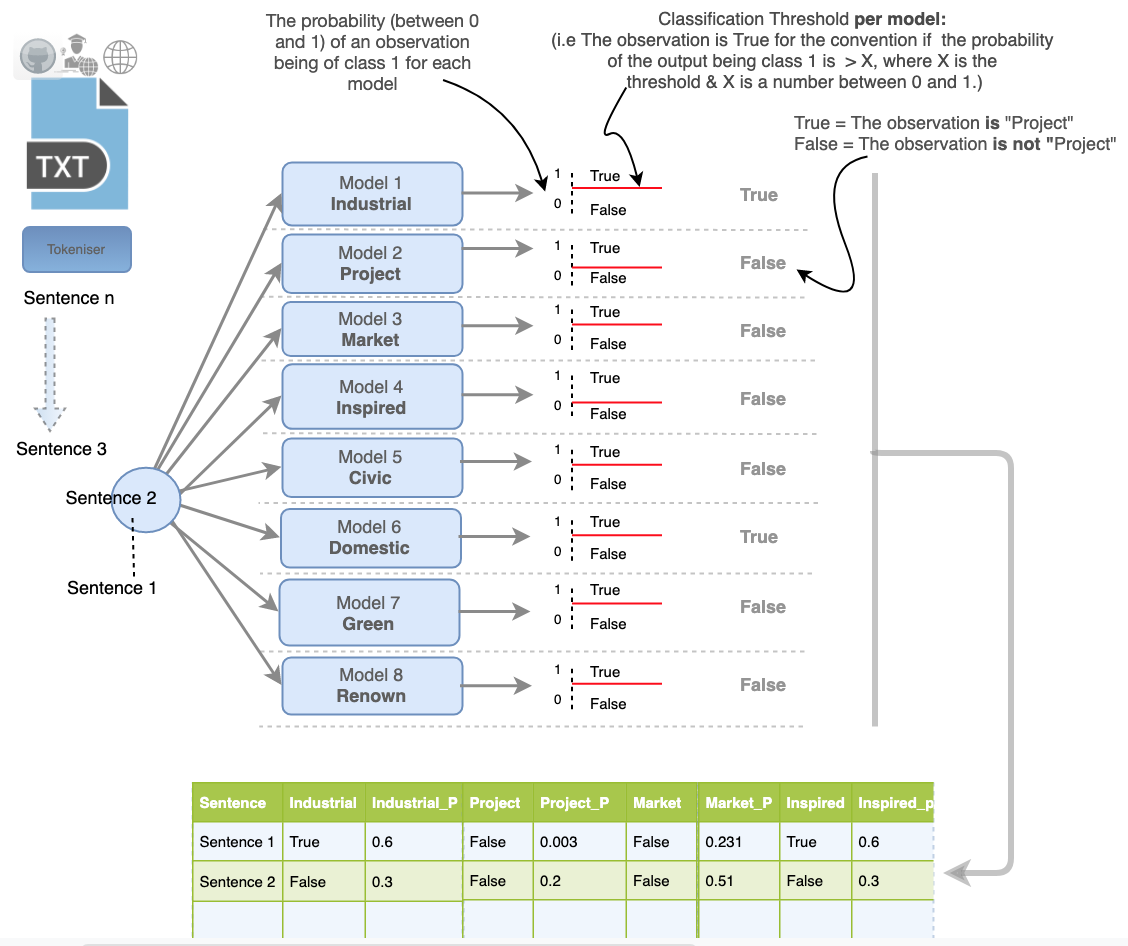

In [13]:
url = 'https://github.com/aideenf/AIVC/raw/master/cp_wssc/Drawings/models.png'
r = req.get(url)
display (PIL_Img.open(BytesIO(r.content)))

# Methods used by various steps

In [21]:
def get_positive_preds_with_threshold(preds, threshold=0.5):
    #Keras .predict returns a list of [x, y] values where x = probability of 0 and y is probability of 1
    #ie 
    preds_results = []
    for j in range(len(preds)):
        #int_pred = int(preds[j][1]>=threshold)
        int_pred = int(preds[j]>=threshold)
        preds_results.append(int_pred)
    return preds_results

def get_positive_preds_probabilities(preds):
    #Keras .predict returns a list of [x, y] values where x = probability of 0 and y is probability of 1
    #i.e preds[j][1] is the probability of a positive prediction.
    preds_results = []
    for j in range(len(preds)):
        int_pred = preds[j][1]
        preds_results.append(int_pred)    
    return preds_results

def apply_pred_threshold(preds, t):
    res = np.zeros(len(preds))  
    res[preds>=t] = 1
    return res

def calculate_metrics(results, num_samples, model):
    
    results.insert(0,'index', range(0,results.shape[0]))
    metrics_df = pd.DataFrame(index = results['index'], columns=['model','threshold','accuracy', 'precision_ppv', 'recall_sensitivity_tpr', 'f1', 'f2', 'f0_5','specifity_selectivity_tnr', 'tpr', 'fpr'])

    for i in results.iterrows():
        
        index, threshold, tp, fp, tn, fn = i[1]

        assert tp + fp + tn + fn == num_samples 
        
        recall = tp / (tp + fn)
        
        if tp == fp == 0:
            precision = 0
            true_positive_rate = 0
        
        else:
            precision = tp / (tp + fp)
            true_positive_rate = tp / (tp + fn)
            
        if precision == recall == 0:
            f1 = 0
            f2 = 0
            f0_5 = 0
            
        else:
            f1 = 2 * (precision * recall) / (precision + recall)
            f2 = (2*2 + 1)*precision*recall / (2*2*precision + recall)#weights recall higher than precision, and 
            f0_5  = (.5*.5 + 1)*precision*recall /(.5*.5*precision + recall)#puts more emphasis on precision than recall.

        
        false_positive_rate = fp / (fp + tn)
        
        accuracy = (tp+tn)/(tp + fp + tn + fn)
        specifity = tn / (tn + fp)
        
        metrics_df.loc[index, 'model'] = model
        metrics_df.loc[index, 'accuracy'] = accuracy
        metrics_df.loc[index, 'precision_ppv'] = precision
        metrics_df.loc[index, 'recall_sensitivity_tpr'] = recall
        metrics_df.loc[index, 'f1'] = f1
        metrics_df.loc[index, 'f2'] = f2
        metrics_df.loc[index, 'f0_5'] = f0_5
        metrics_df.loc[index, 'specifity_selectivity_tnr'] = specifity
        metrics_df.loc[index, 'tpr'] = true_positive_rate
        metrics_df.loc[index, 'fpr'] = false_positive_rate  #inverse recall    
    metrics_df.reset_index()
    metrics_df = pd.concat([results, metrics_df.drop("threshold", axis=1)],axis=1, join='inner', sort = False)
    metrics_df = metrics_df.drop("index", axis=1)
    
    #set the model name to col 0 for consistency
    model = metrics_df.pop('model')
    metrics_df.insert(0, 'model', model)
    return metrics_df


def calculate_full_set_micro_average(results):
    
    metrics_df = pd.DataFrame(columns=['model','threshold','tp', 'fp', 'tn', 'fn', 'accuracy', 'precision_ppv', 'recall_sensitivity_tpr', 'f1', 'f2', 'f0_5','specifity_selectivity_tnr', 'tpr', 'fpr'])    
    tp =  results[0]
    fp =  results[1]
    tn =  results[2]
    fn =  results[3]
  
    recall = tp / (tp + fn)
        
    if tp == fp == 0:
        precision = 0
        true_positive_rate = 0
        
    else:
        precision = tp / (tp + fp)
        true_positive_rate = tp / (tp + fn)
            
    if precision == recall == 0:
        f1 = 0
        f2 = 0
        f0_5 = 0
            
    else:
        f1 = 2 * (precision * recall) / (precision + recall)
        f2 = (2*2 + 1)*precision*recall / (2*2*precision + recall)#weights recall higher than precision, and 
        f0_5  = (.5*.5 + 1)*precision*recall /(.5*.5*precision + recall)#puts more emphasis on precision than recall.

        
    false_positive_rate = fp / (fp + tn)
        
    accuracy = (tp+tn)/(tp + fp + tn + fn)
    specifity = tn / (tn + fp)
    

    metrics_df.loc[0, 'model'] = "set_micro_average"
    metrics_df.loc[0, 'threshold'] = "NaN"
    metrics_df.loc[0, 'tp'] = tp
    metrics_df.loc[0, 'fp'] = fp
    metrics_df.loc[0, 'tn'] = tn
    metrics_df.loc[0, 'fn'] = fn
    metrics_df.loc[0, 'accuracy'] = accuracy
    metrics_df.loc[0, 'precision_ppv'] = precision
    metrics_df.loc[0, 'recall_sensitivity_tpr'] = recall
    metrics_df.loc[0, 'f1'] = f1
    metrics_df.loc[0, 'f2'] = f2
    metrics_df.loc[0, 'f0_5'] = f0_5
    metrics_df.loc[0, 'specifity_selectivity_tnr'] = specifity
    metrics_df.loc[0, 'tpr'] = true_positive_rate
    metrics_df.loc[0, 'fpr'] = false_positive_rate  #inverse recall    
    metrics_df.reset_index()
   
    
    #set the model name to col 0 for consistency
    model = metrics_df.pop('model')
    metrics_df.insert(0, 'model', model)
    
    return metrics_df



# This method returns the validation data either with or without predictions, 
# and either with or without using the isotonic regression models in addition to the 
# classifier models. The thresholds used for the predictions may also be modified,
# the default being 0.5 for all
def process_validation_data(thresholds_in, _DLModels, _DLData_val_x_txt_seq, _DLData_val_x_txt, _DLData_val_y, _DLModelsIsotonicRegression, predict = False, pos_only = False):
    
    thresholds = {'civic': 0.5,
                  'domestic': 0.5,
                  'green': 0.5,
                  'industrial': 0.5,
                  'inspired': 0.5,
                  'market': 0.5,
                  'project': 0.5,
                  'renown': 0.5}
    
    if thresholds_in != None:
        thresholds = thresholds_in
       
    column_list = []
    column_list.append("sequence")
    column_list.append("text")
    column_list.append("convention")
    column_list.append("label")
    
    for conv in _DLModels.keys():
        column_list.append(conv)
        column_list.append(conv+"_prob")
        column_list.append(conv+"_y_pred")
        column_list.append(conv+"_prob_1")
        
    all_validation_df = pd.DataFrame(columns=column_list)
    validation_df = pd.DataFrame(columns=column_list)
    
    #a sub function within the function, just used in this scope 
    def sub_funct_get_prob(prob, y):
        res = []
        for (probability, predicted) in zip(prob, y):
            if predicted == 1:
                res.append(probability)
            if predicted == 0:
                res.append(1 - probability)
        return res
    ####
    
    for conv in _DLModels.keys():
        #loop for ever model
        validation_df = pd.DataFrame(columns=column_list)
        
        #get the validation data sequence for current model and store as string
        data_x = _DLData_val_x_txt_seq[conv]
        validation_df['sequence'] = data_x.tolist()
        validation_df['sequence']= validation_df['sequence'].astype(str)
        
        #get the validation data text for current model
        data_x_txt = _DLData_val_x_txt [conv] 
        validation_df['text'] = data_x_txt
        
        #get the validation data y_actual for current model, add this to column "convention in question" 
        #eg to column 'green' or "industrilal" etc
        #also add this to column label(to work in conj with  column "convention".
        y_actual = [int(x[0]<x[1]) for x in _DLData_val_y[conv]]
        validation_df[conv] = y_actual        
        validation_df['label'] = y_actual

        #Add a column "convention" so we will always know this is originally from "green" etc validation set 
        #This can then work in conjunction with "label" column, eg green -> 0, or green->1 etc
        validation_df['convention'] = conv


        #If predict = True then get prediction from every model and populate the results in the dataframe
        if predict == True:
            
            #first get the prediction for this convenion on its own model
            conv_model = _DLModels[conv]   
            
            #First through our model =
            y_predict = conv_model.predict(data_x)
            
            #get the score for value = 1 as the response is [x,y] we need only the y values
            y_pos_predict_prob = get_positive_preds_probabilities(y_predict)
            
            #convert the probability to 0 or 1 depending on the threshold.
            y_pred = get_positive_preds_with_threshold(y_pos_predict_prob, thresholds[conv])
            
            #if the call has been made with an isotonic reg calibration model too then call its predict.
            if _DLModelsIsotonicRegression != None:
                conv_ir = _DLModelsIsotonicRegression[conv]
                y_pos_predict_isotonic_prob = conv_ir.predict(y_pos_predict_prob)
                y_pred = get_positive_preds_with_threshold(y_pos_predict_isotonic_prob, thresholds[conv])
                y_pos_predict_prob = y_pos_predict_isotonic_prob

            #This is the probability of the y_predict
            validation_df[conv+"_prob"] = sub_funct_get_prob(y_pos_predict_prob , y_pred)
            validation_df[conv+"_y_pred"] = y_pred
            validation_df[conv+"_prob_1"] = y_pos_predict_prob 
    
            #Now put these validation sentences through all the other models.
            #getting a list of all conventions and removing the one we just did
            all_models = list(_DLModels.keys())
            all_other_models = all_models
            all_other_models.remove(conv)
        
            #now for all other models we do the same process
            for model in all_other_models:
                other_model = _DLModels[model]  
                
                #First through the model
                y_predict = other_model.predict(data_x)
                
                #get the score for value = 1 as the response is [x,y] we need only the y values
                y_pos_predict_prob = get_positive_preds_probabilities(y_predict)
                
                #get the 1 or 0 value depending on the threshold
                y_pred = get_positive_preds_with_threshold(y_pos_predict_prob, thresholds[model])
                
                #if the call has been made with an isotonic reg calibration model too then call its predict.
                if _DLModelsIsotonicRegression != None:
                    other_ir = _DLModelsIsotonicRegression[model]
                    y_pos_predict_isotonic_prob = other_ir.predict(y_pos_predict_prob)
                    y_pred = get_positive_preds_with_threshold(y_pos_predict_isotonic_prob, thresholds[model])
                    y_pos_predict_prob = y_pos_predict_isotonic_prob
                
                #this is the y_actual value
                validation_df[model] = 0
                
                #leave this alone as it may have been populated before in its own iteration . later any nAn will be converted
                #validation_df['label']  = 0
                
                #The probability of the y_predict, whether it i 1 or 0
                validation_df[model+"_prob"] =  sub_funct_get_prob(y_pos_predict_prob, y_pred)
                validation_df[model+"_y_pred"] = y_pred
                validation_df[model+"_prob_1"] = y_pos_predict_prob         
       

        #up until this point the correct values are in the dataframe in terms of 1's and 0's            
        all_validation_df = pd.concat([all_validation_df, validation_df] ) 
   
    y_pred_list = []
    for x in all_validation_df.columns.values:
        if x.endswith(('_y_pred')):
            y_pred_list.append(x)
            
    prob_list = []
    conv_list = []
    for x in all_validation_df.columns.values:
        if x.endswith(('_prob')):
            prob_list.append(x)
            conv_list.append(x.replace('_prob', ''))
    
    if predict == True:
        #add the label cardinality as the sum of all the predicted = 1 for sentence for conventions
        pred_sums = all_validation_df[y_pred_list].sum(axis=1)
        all_validation_df['lbl_cnt'] = pred_sums
    
        #add the overall score as the product of all the individual predicted convention scores
        prob_product= all_validation_df[prob_list].prod(axis=1)
        all_validation_df['set_conf'] = prob_product
    
    
    #this will be > 1 if the same sentence was used as True for 2 or more conventions.
    positive_sample = all_validation_df[conv_list].sum(axis=1)
    all_validation_df['pos_sample'] = positive_sample
     
    if pos_only == True:#maybe better to use "label here... not sure yet"
        all_validation_df = all_validation_df.loc[all_validation_df['pos_sample'] > 0].copy()
        print ("Length of positive samples", len(all_validation_df.index))
     
    

    #Check for and remove duplicate rows and duplicate sentences.                                 
    #print ("Number of unique strings", len(all_validation_df['text'].unique()))
    #print ("Length of data frame", len(all_validation_df.index))
    print ("Num Dupes:", len(all_validation_df.index) - len(all_validation_df['text'].unique()) )
    print ("Dropping duplicate rows (these may be duplicate 0's due to training data construction)")
    all_validation_df = all_validation_df.drop_duplicates(keep = "first")
    #everything calculated ok to here, if we want to drop dupes, this line is incorrect.
    
    #all_validation_df = all_validation_df.groupby(['text'], as_index=False).max().sort_values('convention', ascending=True)
    #print ("Number of unique strings after drop", len(all_validation_df['text'].unique()))
    #print ("Length of data frame after drop", len(all_validation_df.index))
    #print ("Num Dupes:", len(all_validation_df.index) - len(all_validation_df['text'].unique()) )
    #print ("Length of data frame after drop NaN", len(df.index))
    return all_validation_df.fillna(0), thresholds
  
def display_validation_data(validation_df):
    display(HTML("Validation Data Analysis, number of sentences per convention"))
    count1 = widgets.HTML(value=pd.DataFrame(validation_df.groupby(['convention','label'])['text'].count()).to_html())
    display (widgets.HBox([count1]))
    
    counts_cross_tab = pd.crosstab(validation_df['label'],validation_df['convention'])
    
    fig = plt.figure(figsize=(16,7))
    axes1 = plt.subplot(1,2,1)
    counts_cross_tab.plot(ax = axes1, kind='bar', title ="Validation data Count")
  
    axes2 = plt.subplot(1,2,2)
    axes2 = model_helpers.label_cardinality_bar(validation_df.drop("convention", axis=1).drop("label", axis=1).drop("text", axis=1)) 
    plt.show()
    
    
    _ = plt.close(fig)
    _ = plt.clf()
    gc.collect()
    

# Review the validation data used during model training
    -we will further review this validation data in order to quantify further the model performance
 

Num Dupes: 120
Dropping duplicate rows (these may be duplicate 0's due to training data construction)


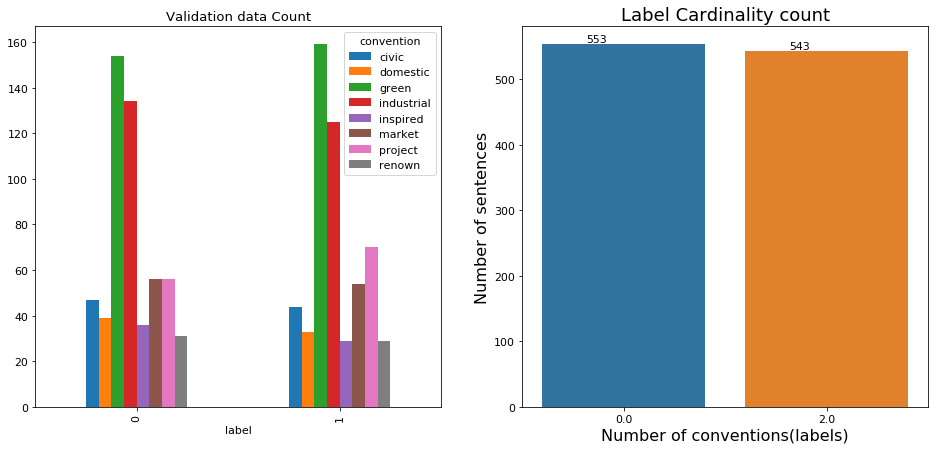

<Figure size 432x288 with 0 Axes>

In [22]:
#Containing all the 1 and 0 samples,however this may not be appropriate for validation as it shows the data as very balanced
#when in reality this is not the case, although a balanced dataset was used for purpose of training. 
#This data may also be misleading if we are to put it through all models as something marked as 0 for green may in fact be
#1 for industrial(or other convention) therefor may be registered as false negative incorrectly by industrial model if 
#we were to leave it in place.
validation_data_from_models, _ =  process_validation_data(None, 
                                                       _DLModels, 
                                                       _DLData_val_x_txt_seq, 
                                                       _DLData_val_x_txt, 
                                                       _DLData_val_y, 
                                                       None, 
                                                       predict = False,
                                                       pos_only = False)
display_validation_data(validation_data_from_models)

# Remove the validation data that is not 1.
The reason we are removing this is because the training data on a per model basis has consisted of samples 
- True(1) for the convention in question
- False(0) for the convention in question (but True(1) for another convention due to the source of 0 samples)

At this point as we are combining the per model validation data into one validation data bucket, it would be incorrect to leave the samples that were "not true" for the individual models as they will be true for one of the other conventions and marking them as 0/False/Not True would provide misleading amalysis of preformance of overall model set. Also for purposes of calibration this should give a better(although not entirely true) indication of the prior distribution of conventions.  


Length of positive samples 543
Num Dupes: 0
Dropping duplicate rows (these may be duplicate 0's due to training data construction)


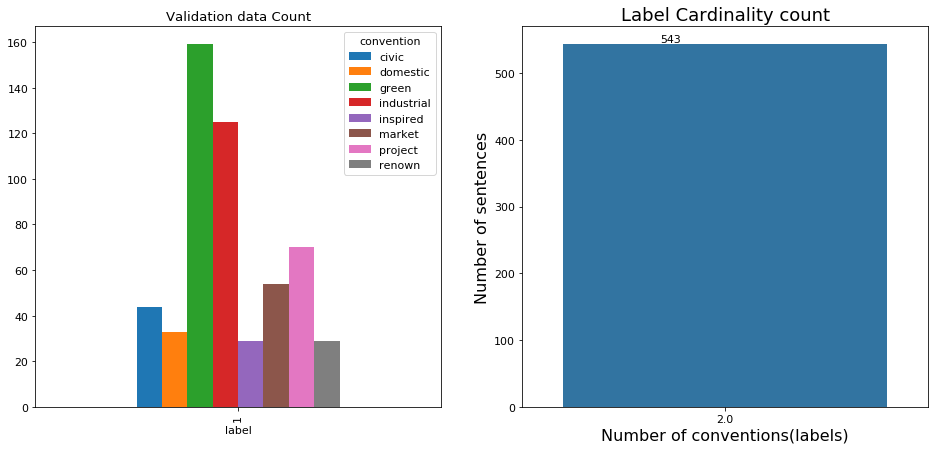

<Figure size 432x288 with 0 Axes>

In [23]:
validation_data_pos_from_models, _ = process_validation_data(None,
                                                             _DLModels,
                                                             _DLData_val_x_txt_seq,
                                                             _DLData_val_x_txt,
                                                             _DLData_val_y,
                                                             None,
                                                             predict=False,
                                                             pos_only=True)

display_validation_data(validation_data_pos_from_models)

In [24]:
print("quick check for duplicate strings:")
print("Number of unique strings", len(
    validation_data_pos_from_models['text'].unique()))
print("Length of data frame", len(validation_data_pos_from_models.index))

quick check for duplicate strings:
Number of unique strings 543
Length of data frame 543


# Calibration of individual model confidence (Re-scaling operation) - The probability associated with the predicted class label should reflect its ground truth correctness likelihood. log-loss optimization

<B> The score that each of our 8 convention models gives a sentence is not necessarally the probability that the sentence reflects that convention</B>

Now we have our simple multi-label "Binary Relevance(BR)" classifier i.e  one binary classifier for each of our 8 labels(conventions). BR has two well-known drawbacks. First, BR neglects label dependencies and this often leads to prediction errors: some BR predictions are incomplete, eg. tagging cat but not animal for an image, and some are conflicting, such as predicting both the code "Pain in left knee" and the code "Pain in unspecified knee" for a medical note." In our case there are no label dependencies(no convention dependencies) so this drawback is not an issue.

The second drawback is that the overall set is often not well calibrated. In order for the overall set to be well calibrated the first task will be to ensure that each individula model is well calibrated. A natural requirement in many end-use applications is that the classifier provides a well-calibrated confidence (probability) to indicate the likelihood of the predicted set being correct; for example, an application may automate high-confidence predictions while manually verifying low-confidence predictions. The established procedures are isotonic regression or Platt scaling) "In machine learning, Platt scaling or Platt calibration is a way of transforming the outputs of a classification model into a probability distribution over classes. The method was invented by John Platt in the context of  support vector machines, replacing an earlier method by Vapnik, but can be applied to other classification models. Platt scaling works by fitting a logistic regression model to a classifier's scores." Isotonic regression has been shown to work better than Platt scaling, in particular when enough training data is available. Isotonic Regression is similar to Platt Scaling. It’s a non-parametric regression technique. Non-parametric means that it doesn’t make any assumptions such as of linearity among variables, constant error variance etc. The only difference lies in the function being fit. The function we fit in isotonic regression continuously increases/decreases.  

So at this point the overall system is predicting  the probability that a sentence belonging 
to each of the eight conventions.  In general, the distribution of these probabilities per classifier may 
not match the expected distribution of observed probabilities. The distribution of the probabilities is therefor calibrated(or adjusted) to better match the expected distribution observed in the data. As mentioned this adjustment is a rescaling operation applied after the predictions have been made by the models. This calibration or scaling can be achieved by using for example, Platt Scaling or Isotonic Regression.


A probabilistic model is well calibrated if for example when we 'bin' the test samples based on their predicted probabilities and when we then examine each bin’s true outcomes, the true outcome should have a proportion close to the probabilities in the bin.  If we predict that we are 99% sure, and if we are only right 50% of the time, this is not calibrated because our estimation was too optimistic. Similarly, if we predict that we are only 60% sure, and we are right 80% of the time, this is not calibrated because our estimation was too pessimistic.

If we split our probability 0 to 1 into 10 bins (0-0.1, 0.1-0.2,.... 0.8 to 1) then in the .8 bin 80% of the predictions should in theory be correct(based on true outcomes) as this would basically imply an 80% confidence rating. This information can be reflected in a reliability diagram(or calibration plot). Well calibrated classifiers are probabilistic classifiers for which the output of the predict_proba method can be directly interpreted as a confidence level. For instance, a well calibrated (binary) classifier should classify the samples such that among the samples to which it gave a predict_proba value close to 0.8, approximately 80% actually belong to the positive class.

NOTE: For each bin, the mean predicted value is plotted against the true fraction of positive cases. If the model is well calibrated the points will fall near the diagonal line.

below we plot the reliability diagram for each of our 8 models, against a version calibrated with isotonic regression. 

On real problems where the true conditional probabilities are not known, model calibration can be visualized with reliability diagrams (DeGroot & Fienberg, 1982). First, the prediction space is discretized into ten bins. Cases with predicted value between 0 and 0.1 fall in the first bin, between 0.1 and 0.2 in the second bin, etc. For each bin, the mean predicted value is plotted against the true fraction of positive cases. If the model is well calibrated the points will fall near the diagonal line.


Information on metrics https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/
Information on kullback leibler https://bigdatascientistblog.wordpress.com/2017/09/11/a-simple-introduction-to-kullback-leibler-divergence-through-python-code/

* Normalized kullback leibler divergence without calibration:  0.7258129169881231
* Normalized kullback leibler divergence with calibration:  0.5745518836943801

In a way this metric measures the quality of predictions rather than the accuracy. 
* log loss(cross entropy) without calibration:  0.4713257179023049
* log loss(cross entropy) with calibration:  0.15580253827165155

* Brier score(MSE) without calibration:  0.13567031758125006
* Brier score(MSE) with calibration:  0.04203803674810543

* ROC AUC score without calibration:  0.8906449262160685
* ROC AUC score with calibration:  0.906494807797413


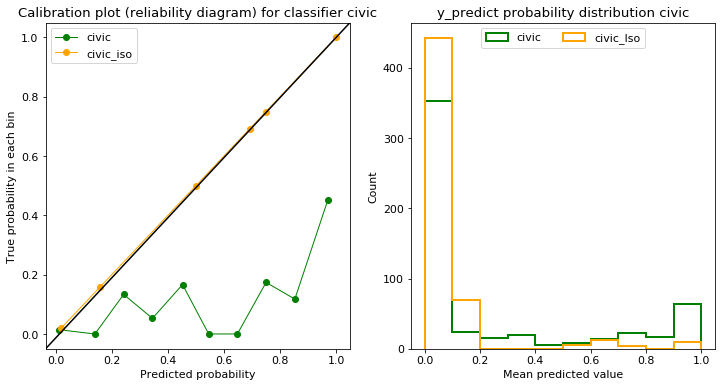

Information on metrics https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/
Information on kullback leibler https://bigdatascientistblog.wordpress.com/2017/09/11/a-simple-introduction-to-kullback-leibler-divergence-through-python-code/

* Normalized kullback leibler divergence without calibration:  0.7397162788002001
* Normalized kullback leibler divergence with calibration:  0.6498479348520556

In a way this metric measures the quality of predictions rather than the accuracy. 
* log loss(cross entropy) without calibration:  0.8062984978867523
* log loss(cross entropy) with calibration:  0.14159071449735444

* Brier score(MSE) without calibration:  0.19960140685100122
* Brier score(MSE) with calibration:  0.0414718800723383

* ROC AUC score without calibration:  0.8979203802733214
* ROC AUC score with calibration:  0.9118241235888295


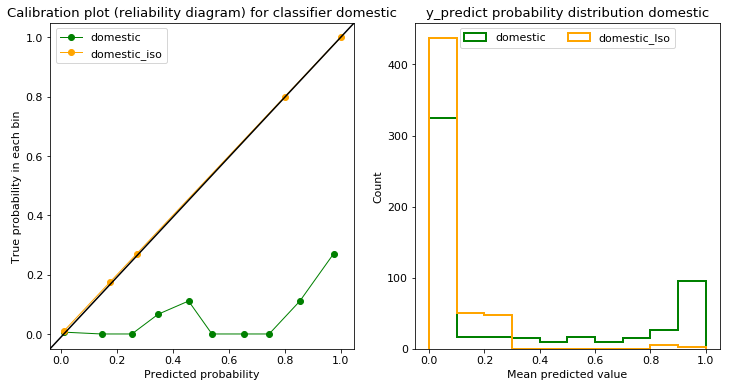

Information on metrics https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/
Information on kullback leibler https://bigdatascientistblog.wordpress.com/2017/09/11/a-simple-introduction-to-kullback-leibler-divergence-through-python-code/

* Normalized kullback leibler divergence without calibration:  0.2665863627454359
* Normalized kullback leibler divergence with calibration:  0.11384669015156512

In a way this metric measures the quality of predictions rather than the accuracy. 
* log loss(cross entropy) without calibration:  0.21407995983339626
* log loss(cross entropy) with calibration:  0.10041662207492551

* Brier score(MSE) without calibration:  0.03728312715823353
* Brier score(MSE) with calibration:  0.028116440547379776

* ROC AUC score without calibration:  0.9846042976939203
* ROC AUC score with calibration:  0.987372248427673


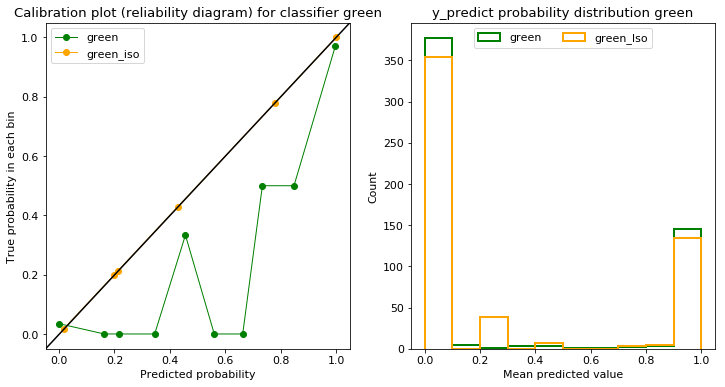

Information on metrics https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/
Information on kullback leibler https://bigdatascientistblog.wordpress.com/2017/09/11/a-simple-introduction-to-kullback-leibler-divergence-through-python-code/

* Normalized kullback leibler divergence without calibration:  0.4114988572220428
* Normalized kullback leibler divergence with calibration:  0.3006542749627108

In a way this metric measures the quality of predictions rather than the accuracy. 
* log loss(cross entropy) without calibration:  0.6532056878123014
* log loss(cross entropy) with calibration:  0.2606077559972426

* Brier score(MSE) without calibration:  0.11988575508147738
* Brier score(MSE) with calibration:  0.08254231595490032

* ROC AUC score without calibration:  0.9287081339712919
* ROC AUC score with calibration:  0.9349186602870813


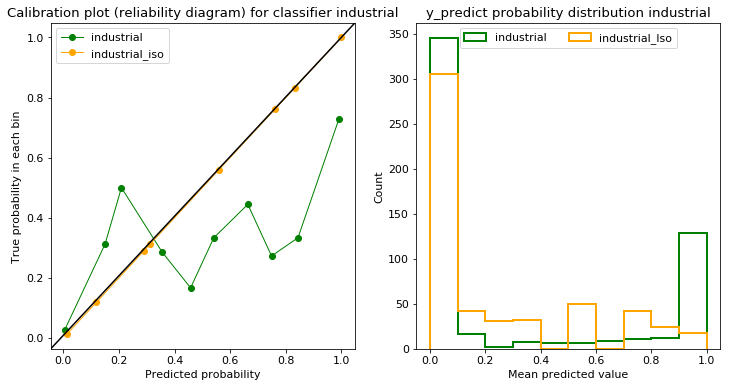

Information on metrics https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/
Information on kullback leibler https://bigdatascientistblog.wordpress.com/2017/09/11/a-simple-introduction-to-kullback-leibler-divergence-through-python-code/

* Normalized kullback leibler divergence without calibration:  0.7513640117100908
* Normalized kullback leibler divergence with calibration:  0.6407377052986856

In a way this metric measures the quality of predictions rather than the accuracy. 
* log loss(cross entropy) without calibration:  0.5571400913001273
* log loss(cross entropy) with calibration:  0.12321700429124544

* Brier score(MSE) without calibration:  0.16195161324947424
* Brier score(MSE) with calibration:  0.03523714121520914

* ROC AUC score without calibration:  0.9070173084663893
* ROC AUC score with calibration:  0.9224137931034483


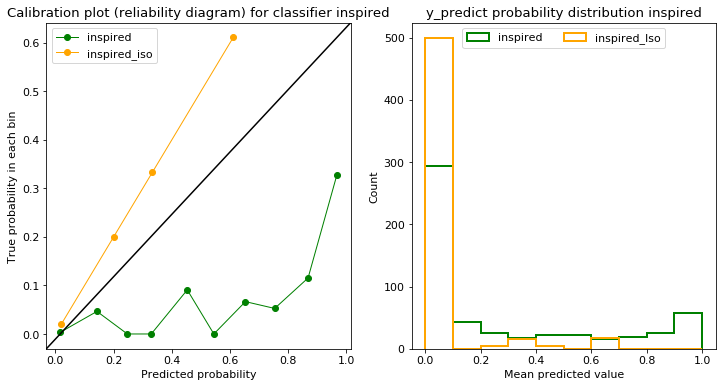

Information on metrics https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/
Information on kullback leibler https://bigdatascientistblog.wordpress.com/2017/09/11/a-simple-introduction-to-kullback-leibler-divergence-through-python-code/

* Normalized kullback leibler divergence without calibration:  0.6379390647868146
* Normalized kullback leibler divergence with calibration:  0.5287454343071589

In a way this metric measures the quality of predictions rather than the accuracy. 
* log loss(cross entropy) without calibration:  0.4697578280506851
* log loss(cross entropy) with calibration:  0.17951134798722457

* Brier score(MSE) without calibration:  0.1388623042035309
* Brier score(MSE) with calibration:  0.051599324298106264

* ROC AUC score without calibration:  0.8992653184882223
* ROC AUC score with calibration:  0.9130689994698175


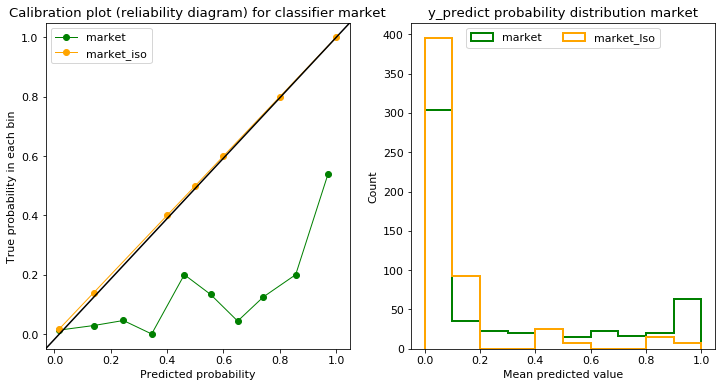

Information on metrics https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/
Information on kullback leibler https://bigdatascientistblog.wordpress.com/2017/09/11/a-simple-introduction-to-kullback-leibler-divergence-through-python-code/

* Normalized kullback leibler divergence without calibration:  0.6023206025161305
* Normalized kullback leibler divergence with calibration:  0.5504701164014492

In a way this metric measures the quality of predictions rather than the accuracy. 
* log loss(cross entropy) without calibration:  0.6450528253718094
* log loss(cross entropy) with calibration:  0.25767004013323497

* Brier score(MSE) without calibration:  0.1821351465100751
* Brier score(MSE) with calibration:  0.08152869704630675

* ROC AUC score without calibration:  0.8639987919057688
* ROC AUC score with calibration:  0.8776049531863486


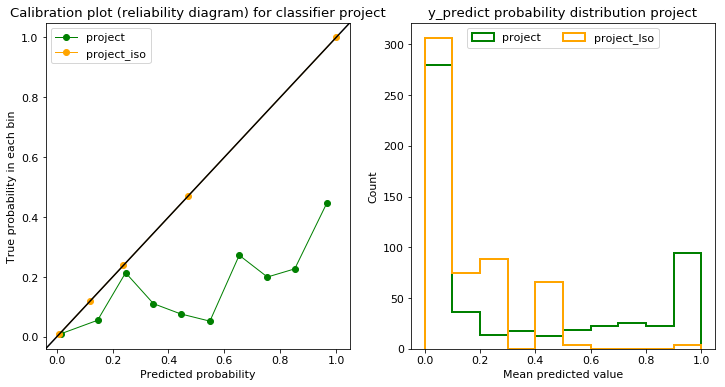

Information on metrics https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/
Information on kullback leibler https://bigdatascientistblog.wordpress.com/2017/09/11/a-simple-introduction-to-kullback-leibler-divergence-through-python-code/

* Normalized kullback leibler divergence without calibration:  0.8064905043551409
* Normalized kullback leibler divergence with calibration:  0.710559805383213

In a way this metric measures the quality of predictions rather than the accuracy. 
* log loss(cross entropy) without calibration:  0.5213701349015433
* log loss(cross entropy) with calibration:  0.1368373891929042

* Brier score(MSE) without calibration:  0.1726730247233563
* Brier score(MSE) with calibration:  0.036427245163389584

* ROC AUC score without calibration:  0.8628740104655843
* ROC AUC score with calibration:  0.8869582718368443


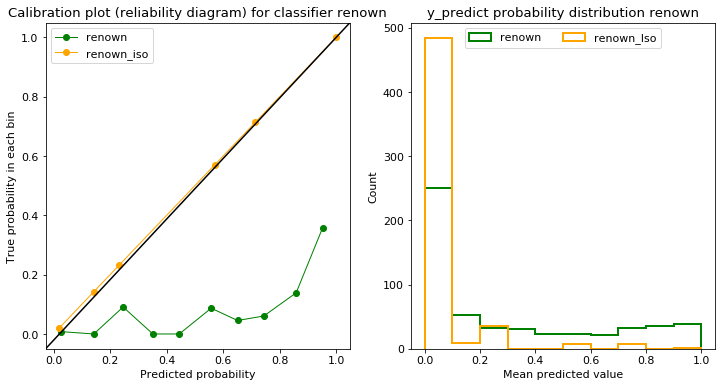

<Figure size 432x288 with 0 Axes>

In [25]:

def get_X_y_from_combined_pd(validation_data, convention):
    # sequence, for validation_data['convention'] == convention
    data_x_1 = validation_data.loc[validation_data['convention']== convention, 'sequence']
    data_x_0 = validation_data.loc[validation_data['convention']!= convention, 'sequence']
    # sequence is stored as a string so here we convert it back.
    data_x = []
    data_x_1 = list(data_x_1)
    data_x_0 = list(data_x_0)
    for seq, index in zip(data_x_1, range(len(data_x_1))):
        data_x.append(
            list(map(int, data_x_1[index].replace('[', '').replace(']', '').split(','))))
    #print ("only sentences true for",convention,len(data_x))
    for seq, index in zip(data_x_0, range(len(data_x_0))):
        data_x.append(
            list(map(int, data_x_0[index].replace('[', '').replace(']', '').split(','))))
    #print ("All sentences", len(data_x))
    data_x = np.asarray((data_x))

    y_actual = []
    y_actual_1 = validation_data.loc[validation_data['convention']
                                     == convention, convention]
    y_actual_0 = validation_data.loc[validation_data['convention']
                                     != convention, convention]
    for y in y_actual_1:
        y_actual.append(y)
    #print ("only sentences true for",convention,len(data_x))
    for y in y_actual_0:
        y_actual.append(y)
    #print ("All sentences", len(data_x))
    return data_x, y_actual

# cv_isotonic = CalibratedClassifierCV(None, cv=prefit, method='isotonic')
# cv_sigmoid = CalibratedClassifierCV(None, cv=prefit, method='sigmoid')       
# cv_isotonic.fit(X_train, y_train, sw_train)
# prob_pos_isotonic = cv_isotonic.predict_proba(X_test)[:, 1]
# cv_sigmoid.fit(X_train, y_train, sw_train)
# prob_pos_sigmoid = cv_sigmoid.predict_proba(X_test)[:, 1]
def calibrate_models_view_reliability(validation_data, _DLModels, _DLModelsIsotonicRegression, _DLData_val_x_txt_seq, _DLData_val_x_txt, _DLData_val_y, combined_data):
    display(HTML("<font color = 'green'><h3><left>Calibration plot generated via sklearn.calibration.calibration_curve <br/> Isotonic calibration applied using sklearn.isotonic.IsotonicRegression</left></h3></font>"))
    display(HTML("Isotonic Regression is similar to Platt Scaling. It’s a non-parametric regression technique. Non-parametric means that it doesn’t make any assumptions such as of linearity among variables, constant error variance etc. Note that calibration will not improve accuracy but rather will improve log-loss. The goal of our machine learning models is to minimize this value. A perfect model would have a log loss of 0."))
    print("On real problems where the true conditional probabilities are not known, model calibration can be visualized with reliability diagrams (DeGroot & Fienberg, 1982). First, the prediction space is discretized into ten bins. Cases with predicted value between 0 and 0.1 fall in the first bin, between 0.1 and 0.2 in the second bin, etc. For each bin, the mean predicted value is plotted against the true fraction of positive cases. If the model is well calibrated the points will fall near the diagonal line.")
    for convention in _DLModels.keys():
        display(HTML("<font color = 'green'><h3><left>" +
                     convention + "</left></h3></font>"))
        
        _DLModelsIsotonicRegression[convention] = IsotonicRegression(
            out_of_bounds='clip')
        # get the model, the validation data input(data_x) and the predicted label(preds) to compare to the actual label(y_actual).
        model = _DLModels[convention]

        if (combined_data == False):
            # show the reliability and calibrate with the seperated balanced data
            data_x = _DLData_val_x_txt_seq[convention]
            y_actual = [int(x[0] < x[1]) for x in _DLData_val_y[convention]]

        elif (combined_data == True):
            # show the reliability and calibrate with the combined unbalanced data
            data_x, y_actual = get_X_y_from_combined_pd(validation_data, convention)

        # data_x and y_actual generated, now both flows are same
        y_predict = model.predict(data_x)
        y_predict = get_positive_preds_probabilities(y_predict)
        
        _DLModelsIsotonicRegression[convention].fit(y_predict, y_actual)
        y_predict_isotonic = _DLModelsIsotonicRegression[convention].predict(
            y_predict)

        def kl_norm(x):
            return (2 * (math.exp(x) / (math.exp(x)+1))) - 1

        kullback_leibler_before = kl_norm(stats.entropy(y_actual, y_predict))
        kullback_leibler_after = kl_norm(
            stats.entropy(y_actual, y_predict_isotonic))

        log_loss_before = log_loss(y_actual, y_predict, eps=1e-7)
        log_loss_after = log_loss(y_actual, y_predict_isotonic, eps=1e-7)
        brier_score_before = brier_score_loss(y_actual, y_predict)
        brier_score_after = brier_score_loss(y_actual, y_predict_isotonic)
        roc_auc_score_before = roc_auc_score(y_actual, y_predict)
        roc_auc_score_after = roc_auc_score(y_actual, y_predict_isotonic)
        # Plot the calibration curves for test data which is not callibrated and test data which is callibrated
        y, x = calibration_curve(y_actual, y_predict, n_bins=10)
        y_iso, x_iso = calibration_curve(
            y_actual, y_predict_isotonic, n_bins=10)
        print("Information on metrics https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/")
        print("Information on kullback leibler https://bigdatascientistblog.wordpress.com/2017/09/11/a-simple-introduction-to-kullback-leibler-divergence-through-python-code/")

        print("")
        print("* Normalized kullback leibler divergence without calibration: ",
              kullback_leibler_before)
        print("* Normalized kullback leibler divergence with calibration: ",
              kullback_leibler_after)
        print("")
        print("In a way this metric measures the quality of predictions rather than the accuracy. ")
        print("* log loss(cross entropy) without calibration: ", log_loss_before)
        print("* log loss(cross entropy) with calibration: ", log_loss_after)
        print("")
        print("* Brier score(MSE) without calibration: ", brier_score_before)
        print("* Brier score(MSE) with calibration: ", brier_score_after)
        print("")
        print("* ROC AUC score without calibration: ", roc_auc_score_before)
        print("* ROC AUC score with calibration: ", roc_auc_score_after)

        _ = plt.figure(figsize=(12, 6))
        _ = plt.rcParams.update({'font.size': 11})
        _ = plt.rcParams.update({'font.weight': 'normal'})

        ax = plt.subplot(1, 2, 1)
        # only these two lines are calibration curves
        _ = plt.plot(x, y, marker='o', linewidth=1,
                     label=convention, color='green')
        
        _ = plt.plot(x_iso, y_iso, marker='o', linewidth=1,
                     label=convention+'_iso', color='orange')

        # reference line, legends, and axis labels
        line = mlines.Line2D([0, 1], [0, 1], color='black')
        transform = ax.transAxes
        _ = line.set_transform(transform)
        _ = ax.add_line(line)
        ax.set_title(
            'Calibration plot (reliability diagram) for classifier ' + convention)
        _ = ax.set_xlabel('Predicted probability')
        _ = ax.set_ylabel('True probability in each bin')
        _ = plt.legend()

        ax2 = plt.subplot(1, 2, 2)
        ax2.set_title('y_predict probability distribution ' + convention)
        _ = ax2.hist(y_predict, range=(0, 1), bins=10, label=convention,
                     histtype="step", lw=2, color="green")
        _ = ax2.hist(y_predict_isotonic, range=(0, 1), bins=10, label=convention + '_Iso',
                     histtype="step", lw=2, color="orange")
        _ = ax2.set_xlabel("Mean predicted value")
        _ = ax2.set_ylabel("Count")
        _ = ax2.legend(loc="upper center", ncol=2)

        plt.show()
    plt.clf()
    gc.collect()
    return _DLModelsIsotonicRegression


#display (HTML ("<font color = 'red'><h3><left>Running Calibration plot and calibration method against the still seperate and balanced validation data</left></h3></font>"))
#_DLModelsIsotonicRegression = calibrate_models_view_reliability (None, _DLModels, _DLModelsIsotonicRegression.copy(), _DLData_val_x_txt_seq, _DLData_val_x_txt, _DLData_val_y, combined_data = False)

display(HTML("<font color = 'red'><h3><left>Running Calibration plot and calibration method against the combined and unbalanced validation data</left></h3></font>"))
# Here we are calling the calibration method on the "validation_data_pos_from_models" dataset which is the combined
# validation data with the 0 values removed, as discussed above. The method returns the set (one per model)
# of isotonic regression mocels.
_DLModelsIsotonicRegression = calibrate_models_view_reliability(
    validation_data_pos_from_models, _DLModels, _DLModelsIsotonicRegression.copy(), None, None, None, combined_data=True)

# Now we have a composition of the classifier prediction followed by the isotonic regression model prediction to provide final prediction. 
we are calling process validation data (only the 1 values

In [26]:
# Now we can process the validation data, with predict = true and usng the models followed by the Isotonic Regression model. 
# we will use the default thresholds of 0.5, 

validation_data_pos_with_pred, thresh = process_validation_data(None, 
                                                          _DLModels, 
                                                          _DLData_val_x_txt_seq, 
                                                          _DLData_val_x_txt, 
                                                          _DLData_val_y, 
                                                          _DLModelsIsotonicRegression, 
                                                          predict = True,
                                                          pos_only = True)


Length of positive samples 543
Num Dupes: 0
Dropping duplicate rows (these may be duplicate 0's due to training data construction)


# Counting based on calibrated probabilistic output
note that we have two tasks:
    - "Quantification": whereby we need to determine the distribution of conventions amongst the data to be analyze (github and ss)
    - "Multi lable, multi class Classification": In order to facilitate active learning we need to 
    accurately classify the analyzed data for the purpose of auditing random samples and providing additional iterative training data

In [172]:
def get_count_per_model(model, df, num_bins, thresholds):
    #just to remember: we are not using "conf_bin" here it is for the set confidence

    model_count = df[['text', model+'_prob_1',model+'_y_pred', model]].copy()
#   display(model_count.head(3))
    model_count['prob_bin'] = pd.qcut(model_count[ model+'_prob_1'], q=num_bins, duplicates='drop')
    model_grouped_count = model_count.groupby('prob_bin')[model+'_prob_1'].count().copy()
    
    
    mean_prob_per_bucket = []
    occurance_per_bucket = []
    total = 0
    for x in range (len(model_grouped_count)):
        a = model_grouped_count.index.categories[x].left
        b = model_grouped_count.index.categories[x].right
        mean_prob_per_bucket.append (np.mean([a,b]))
        occurance_per_bucket.append (model_grouped_count[x])

    def percentage(percent, whole):
        return (percent * whole) / 100.0
    total = 0
    for prob, occurances in zip(mean_prob_per_bucket,occurance_per_bucket ):
        total = total + percentage(prob*100,occurances)
    
    actual = "not applicable"
    try:
        counts_y_actual = model_count[model]==1
        actual = counts_y_actual.value_counts()[1]
    except:
        actual = "not applicable"
        
    counts_y_predict = model_count[model+'_y_pred']==1
    predict = counts_y_predict.value_counts()[1]
    

    return actual, int(round(total)), predict, thresholds[model]

def get_count(validation_data_pos_with_pred, _DLModels, thresholds, num_prob_buckets = 8, actual=False ):
    plt.clf()
    predicted_prob_count = {}
    predicted_classification_count = {}
    actual_count = {}
    predicted_prob_count_list = []
    predicted_classification_count_list = []
    actual_count_list = []
    model_list = []
    thr_list = []
    thresh = thresholds
    df = pd.DataFrame (columns = ['Convention','Calibrated Prob count','Classifier count','Threshold','True count'])
    for k in _DLModels.keys():
        actual_cnt, prob_cnt, classif_cnt, thr = get_count_per_model(k, validation_data_pos_with_pred, num_prob_buckets, thresh)
        predicted_prob_count[k] = prob_cnt
        predicted_classification_count[k] = classif_cnt
        actual_count[k] = actual_cnt
        
        predicted_prob_count_list.append(prob_cnt)
        predicted_classification_count_list.append(classif_cnt)
        actual_count_list.append(actual_cnt)
        model_list.append(k)
        thr_list.append(thr)
    my_colors = ['orange', 'green',  'red', 'pink', 'purple', 'blue', 'brown', 'black']    
    df['Calibrated Prob count'] = predicted_prob_count_list
    df['Classifier count'] = predicted_classification_count_list
    df['True count'] = actual_count_list
    df['Convention'] = model_list
    df['Threshold'] = thr_list
    choose = []
    choose.append(predicted_prob_count [max(predicted_prob_count, key=predicted_prob_count.get)])
    choose.append(predicted_classification_count [max(predicted_classification_count, key=predicted_classification_count.get)])
    choose.append(actual_count [max(actual_count, key=actual_count.get)])
    
    

    fig = go.Figure(data=[
    go.Bar(name='Calibrated confidence', x=model_list, y=predicted_prob_count_list, textposition='auto'),
    go.Bar(name='Actual count', x=model_list, y=actual_count_list, textposition='auto'),
    go.Bar(name='Predicted by classifier', x=model_list, y=predicted_classification_count_list, textposition='auto'),
    
    ] )
    # Change the bar mode
    fig.update_layout(barmode='group', xaxis_tickangle=-45, title_text='Probabilistic count vs classifier predicted' )#stack
    fig.show()
    return df

display (get_count(validation_data_pos_with_pred, _DLModels, thresh, num_prob_buckets = 8, actual=True ))

,Convention,Calibrated Prob count,Classifier count,Threshold,True count
0,civic,35,32,0.5,44
1,domestic,44,7,0.5,33
2,green,152,144,0.5,159
3,industrial,111,133,0.5,125
4,inspired,28,18,0.5,29
5,market,54,30,0.5,54
6,project,79,8,0.5,70
7,renown,39,15,0.5,29


<Figure size 432x288 with 0 Axes>

# Metrics to help select probability threshold for classification
What is the treshold? Each of our models will return the Probability of a sentence belonging to the convention represented by the model. Now this probability needs to be turned into a Classification.
    - Belongs to the convention (Class 1)
    - Does not belong to the convention (Class 0)

we could say that this classification should occur at probability 0.5 however this may not be the best place to put it and for performance of our overall system this "threshold" may vary per model. We will therefor evaluate each individual models performance for a number of performance matrics, for a selection of different classification thresholds, in order to ultimately determine what Threshold  per model to use on unseen data once the model is live.

First we should review metrics for each individual model. In this case our training and evaluation data for each model is very balanced, in that we have an equal amount of Class 1 and Class 0 training sets per model. This balance has been achieved by data resampling either under-sampling the majority of the class, or over-sampling the minority class, or a mix of both(depending on which of the 8 models is in question). This is something to consider when ultimitely deciding the metric to base our threshold decisions on per model (but we should also keep in mind the overall system and the distribution of conventions in unseen(real world) data. 

The Metrics to evaluate:
    * Where Class 1 = Sentence belongs to Convention
    * Where Class 0 = Sentence does not belongs to Convention
 We evaluate against against a gold standard (or the ‘ground truth’ as it is perceived) i.e the true values v's the models predicted valuse in our test/validation data set. 

//////////////////////////////////////////*ACCURACY*/////////////////////////////////////////////////////////////

    - Accuracy = (TP + TN)/(TP + FP + TN + FN)

The probability that the classification result is correct, ie probability of correctly labeling sentences as class 1 or Class 0, given all the sentences!

Accuracy is simply the ratio of the correctly labeled sentences out of all sentences. Accuracy is a good measure  for well balanced datasets and when false negatives & false positive predictions have a similar 'costs'.

With imbalanced data, for example containing a lower amount of Class 1 compared to Class 0,  proclaiming all sentences as class 0 will have quite a high accuracy due to the low overall presence of Class 1, this may not ultimately be a helpful metric though if the cost of a false negative(false class 0) has a high cost. In the case of each of our individual models, our training data is quite balanced and there is a similar cost for FP and FN. however we need to keep in mind that the overall distribution of data in our overall system is not so evenly distributed across the labels that each model represents. 


////////////////////////////*PRECISION/POSITIVE PREDICTION VALUE*//////////////////////////////////////////////

     - Precision or Positive prediction value =  TP / (TP + FP)
     
The probability that a sentences we have labeled as Class 1(belonging to the convention) is actually Class 1. eg in green model, the probability that a sentenced classified as positive(1) for green, is actually green. 

Our focus then in terms of performance might be on identifying the actually positive cases, i.e to maximize the "precision".  Although a model with umbalanced data could also 'cheat' and maximize this by always returning “negative”. This metric is important if the most important function of the model will be to identify positives (Class 1). If this is a priority then we should choose a model with higher Recall/Sensitivity. 

   
//////////////////////////////*RECALL/SENSITIVITY/TRUE POSITIVE RATE*/////////////////////////////////////////
 
     - Recall or Sensitivity or TPR =  TP / (TP + FN)
     
Given the sentence is part of the convention, how likely is it that the classification will be positive?

Our focus then in terms of performance could maybe be in terms of higher importance on identifying the positive cases, i.e to maximize the "recall" or "sensitivity". Although a model could also 'cheat' and maximize this by always returning “positive”. This metric is important if the most important function of the model will be to identify positives (Class 1). If this is most important to us then we should choose a model with higher Recall/Sensitivity. 

//////////////////////////////*SPECIFITY/TRUE NEGATIVE RATE*//////////////////////////////////////////////////   

    - Specifity or TNR = TN / (TN + FP)

How good a classifier is at avoiding false alarms. Given the sentence does not belong to the convention, how likely is it that the classification will be negative(class 0). If correctly identifying negatives is most important, then we should choose specificity as the measurement metric. A classifier can 'cheat' and maximize this by always returning “negative”/Class 0.


///////////////////////////////////*F1, F2 and F0.5 SCORE*////////////////////////////////////////////////

    - F1 =  2 * ( (Precision * Recall) / (Precision + Recall) )
If we want to find an optimal blend of precision and recall we can combine the two metrics using what is called the F1 score, this is the 'harmonic mean' of precision and recall (harmonic mean is used as it punishes extreme values)

Note: there are other F measures:
F2 which weights recall higher than precision
F0.5 which puts more emphasis on precision than recall.

Fx = (1 + x^2) * ( (precision * recall) / (x^2 *(Precision + Recall)) 


///////////////////////////////////////////////////////////////////////////////////////////////////////////   

It is importalt to look at all relevant metrics instead of just one and to make a decision based on the problem to be resolved (the purpose of the classifier and the importance/impact of incorrectly classifying as positive vs' incorrectly classifying as negative for example it is worse to falsely imprison an innocent person than to let a guilty criminal get away, however the cost attached to FP's and FN'S in our sentence classification is of a different nature. 

    -ROC Curves summarize the trade-off between the true positive rate(recall) and false positive rate for a predictive model. AUC exists independently of a threshold, whereas accuracy / precision / recall / F1-score DO require the picking of a threshold, so we are measuring two different things.

    -Precision-Recall curves summarize the trade-off between the recall(true positive rate) and the Precision(positive predictive value) for a predictive model using different probability thresholds.

Note: ROC curves are appropriate when the observations are balanced between each class, whereas precision-recall curves are appropriate for imbalanced datasets.


     -Log Loss: This Evaluation Metric is employed in the classification tasks where rather than predicting the actual classes, one needs to predict the probabilities corresponding to that classes. So, in a way this metric measures the quality of predictions rather than the accuracy.

Metrics for civic per Classification Threshold


,model,threshold,tp,fp,tn,fn,accuracy,precision_ppv,recall_sensitivity_tpr,f1,f2,f0_5,specifity_selectivity_tnr,tpr,fpr
0,civic,0.0,44,499,0,0,0.0810313,0.0810313,1,0.149915,0.305981,0.099278,0,1,1
1,civic,0.1,35,66,433,9,0.861878,0.346535,0.795455,0.482759,0.631769,0.390625,0.867735,0.795455,0.132265
2,civic,0.2,24,8,491,20,0.948435,0.75,0.545455,0.631579,0.576923,0.697674,0.983968,0.545455,0.0160321
3,civic,0.3,24,8,491,20,0.948435,0.75,0.545455,0.631579,0.576923,0.697674,0.983968,0.545455,0.0160321
4,civic,0.4,24,8,491,20,0.948435,0.75,0.545455,0.631579,0.576923,0.697674,0.983968,0.545455,0.0160321
5,civic,0.5,24,8,491,20,0.948435,0.75,0.545455,0.631579,0.576923,0.697674,0.983968,0.545455,0.0160321
6,civic,0.6,21,5,494,23,0.948435,0.807692,0.477273,0.6,0.519802,0.709459,0.98998,0.477273,0.01002
7,civic,0.7,12,1,498,32,0.939227,0.923077,0.272727,0.421053,0.31746,0.625,0.997996,0.272727,0.00200401
8,civic,0.8,9,0,499,35,0.935543,1,0.204545,0.339623,0.243243,0.5625,1,0.204545,0
9,civic,0.9,9,0,499,35,0.935543,1,0.204545,0.339623,0.243243,0.5625,1,0.204545,0


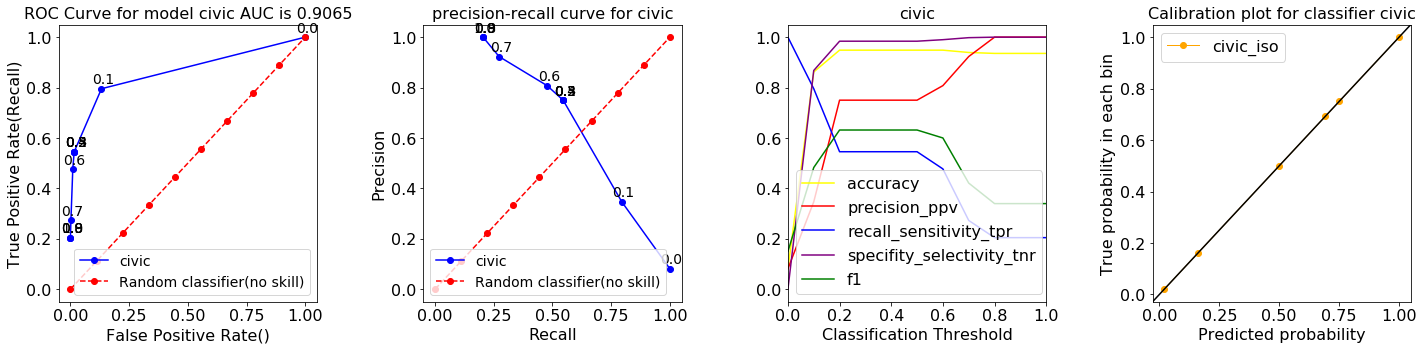

Max evaluation metric for model civic
* Accuracy:  0.9484346224677717 at threshold  0.2
* Precision:  1.0 at threshold  0.8
* Recall:  1.0 at threshold  0.0
* F1:  0.631578947368421 at threshold  0.2
* ROC-AUC 0.9065
* Log Loss 0.15580253827165155



Metrics for domestic per Classification Threshold


,model,threshold,tp,fp,tn,fn,accuracy,precision_ppv,recall_sensitivity_tpr,f1,f2,f0_5,specifity_selectivity_tnr,tpr,fpr
0,domestic,0.0,33,510,0,0,0.0607735,0.0607735,1,0.114583,0.244444,0.0748299,0,1,1
1,domestic,0.1,28,78,432,5,0.847145,0.264151,0.848485,0.402878,0.588235,0.306346,0.847059,0.848485,0.152941
2,domestic,0.2,19,36,474,14,0.907919,0.345455,0.575758,0.431818,0.508021,0.375494,0.929412,0.575758,0.0705882
3,domestic,0.3,6,1,509,27,0.948435,0.857143,0.181818,0.3,0.215827,0.491803,0.998039,0.181818,0.00196078
4,domestic,0.4,6,1,509,27,0.948435,0.857143,0.181818,0.3,0.215827,0.491803,0.998039,0.181818,0.00196078
5,domestic,0.5,6,1,509,27,0.948435,0.857143,0.181818,0.3,0.215827,0.491803,0.998039,0.181818,0.00196078
6,domestic,0.6,6,1,509,27,0.948435,0.857143,0.181818,0.3,0.215827,0.491803,0.998039,0.181818,0.00196078
7,domestic,0.7,6,1,509,27,0.948435,0.857143,0.181818,0.3,0.215827,0.491803,0.998039,0.181818,0.00196078
8,domestic,0.8,6,1,509,27,0.948435,0.857143,0.181818,0.3,0.215827,0.491803,0.998039,0.181818,0.00196078
9,domestic,0.9,2,0,510,31,0.94291,1,0.0606061,0.114286,0.0746269,0.243902,1,0.0606061,0


<Figure size 432x288 with 0 Axes>

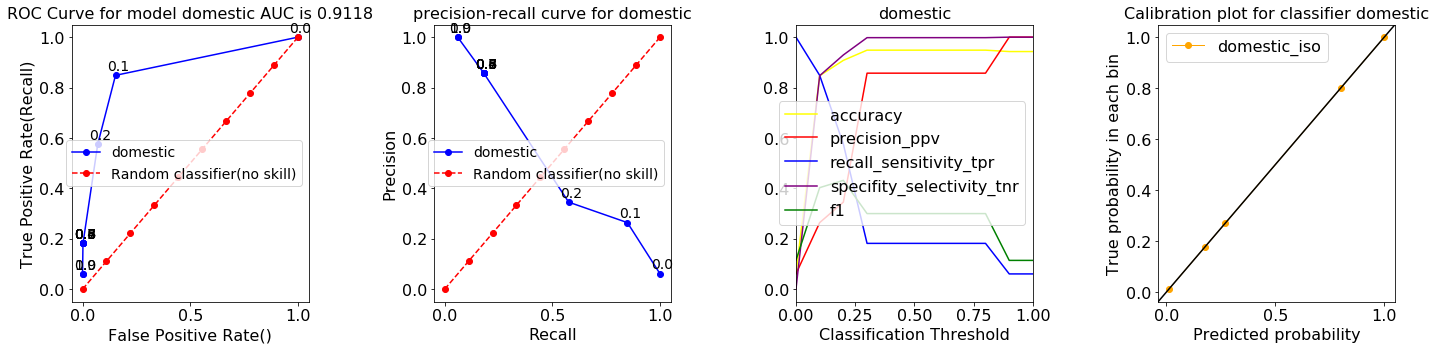

Max evaluation metric for model domestic
* Accuracy:  0.9484346224677717 at threshold  0.3
* Precision:  1.0 at threshold  0.9
* Recall:  1.0 at threshold  0.0
* F1:  0.4318181818181818 at threshold  0.2
* ROC-AUC 0.9118
* Log Loss 0.14159071449735444



Metrics for green per Classification Threshold


,model,threshold,tp,fp,tn,fn,accuracy,precision_ppv,recall_sensitivity_tpr,f1,f2,f0_5,specifity_selectivity_tnr,tpr,fpr
0,green,0.0,159,384,0,0,0.292818,0.292818,1,0.452991,0.6743,0.341055,0,1,1
1,green,0.1,153,36,348,6,0.922652,0.809524,0.962264,0.87931,0.927273,0.836066,0.90625,0.962264,0.09375
2,green,0.2,153,36,348,6,0.922652,0.809524,0.962264,0.87931,0.927273,0.836066,0.90625,0.962264,0.09375
3,green,0.3,145,6,378,14,0.963168,0.960265,0.91195,0.935484,0.92122,0.950197,0.984375,0.91195,0.015625
4,green,0.4,145,6,378,14,0.963168,0.960265,0.91195,0.935484,0.92122,0.950197,0.984375,0.91195,0.015625
5,green,0.5,142,2,382,17,0.965009,0.986111,0.893082,0.937294,0.910256,0.965986,0.994792,0.893082,0.00520833
6,green,0.6,142,2,382,17,0.965009,0.986111,0.893082,0.937294,0.910256,0.965986,0.994792,0.893082,0.00520833
7,green,0.7,142,2,382,17,0.965009,0.986111,0.893082,0.937294,0.910256,0.965986,0.994792,0.893082,0.00520833
8,green,0.8,139,1,383,20,0.961326,0.992857,0.874214,0.929766,0.895619,0.96662,0.997396,0.874214,0.00260417
9,green,0.9,135,0,384,24,0.955801,1,0.849057,0.918367,0.875486,0.965665,1,0.849057,0


<Figure size 432x288 with 0 Axes>

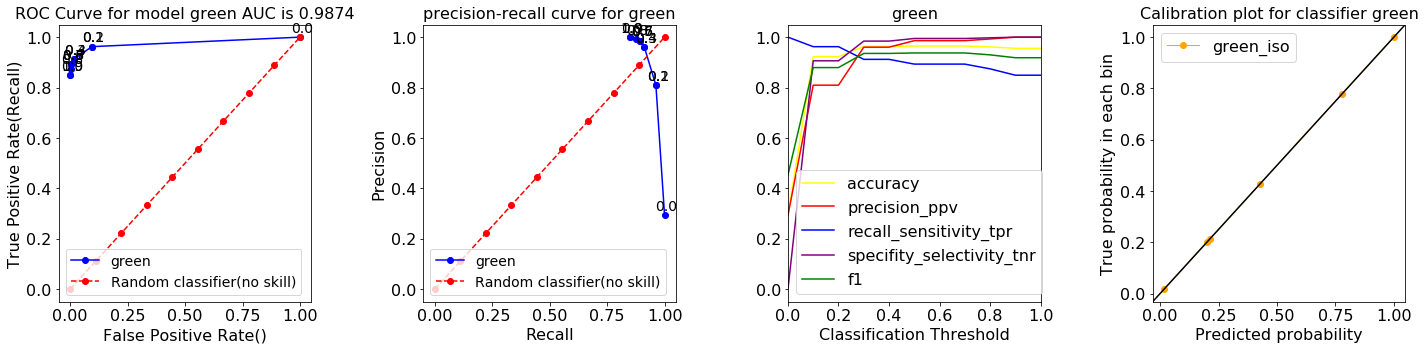

Max evaluation metric for model green
* Accuracy:  0.9650092081031307 at threshold  0.5
* Precision:  1.0 at threshold  0.9
* Recall:  1.0 at threshold  0.0
* F1:  0.9372937293729373 at threshold  0.5
* ROC-AUC 0.9874
* Log Loss 0.10041662207492551



Metrics for industrial per Classification Threshold


,model,threshold,tp,fp,tn,fn,accuracy,precision_ppv,recall_sensitivity_tpr,f1,f2,f0_5,specifity_selectivity_tnr,tpr,fpr
0,industrial,0.0,125,418,0,0,0.230203,0.230203,1,0.374251,0.599233,0.272094,0,1,1
1,industrial,0.1,121,117,301,4,0.777164,0.508403,0.968,0.666667,0.819783,0.561746,0.720096,0.968,0.279904
2,industrial,0.2,116,80,338,9,0.836096,0.591837,0.928,0.722741,0.833333,0.638064,0.808612,0.928,0.191388
3,industrial,0.3,107,58,360,18,0.860037,0.648485,0.856,0.737931,0.804511,0.681529,0.861244,0.856,0.138756
4,industrial,0.4,97,36,382,28,0.882136,0.729323,0.776,0.751938,0.766193,0.738204,0.913876,0.776,0.0861244
5,industrial,0.5,97,36,382,28,0.882136,0.729323,0.776,0.751938,0.766193,0.738204,0.913876,0.776,0.0861244
6,industrial,0.6,69,14,404,56,0.871087,0.831325,0.552,0.663462,0.591767,0.754923,0.966507,0.552,0.0334928
7,industrial,0.7,69,14,404,56,0.871087,0.831325,0.552,0.663462,0.591767,0.754923,0.966507,0.552,0.0334928
8,industrial,0.8,37,4,414,88,0.830571,0.902439,0.296,0.445783,0.341959,0.640138,0.990431,0.296,0.00956938
9,industrial,0.9,17,0,418,108,0.801105,1,0.136,0.239437,0.16441,0.440415,1,0.136,0


<Figure size 432x288 with 0 Axes>

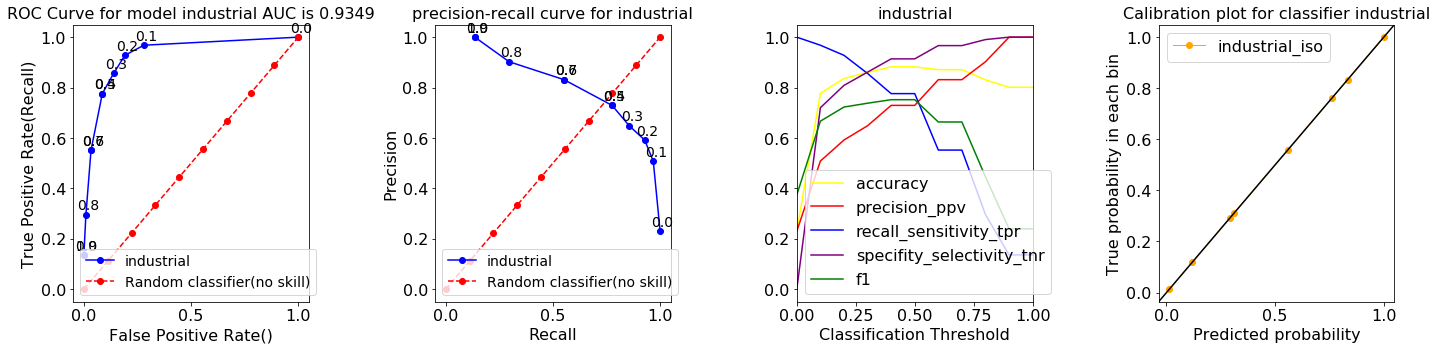

Max evaluation metric for model industrial
* Accuracy:  0.8821362799263351 at threshold  0.4
* Precision:  1.0 at threshold  0.9
* Recall:  1.0 at threshold  0.0
* F1:  0.751937984496124 at threshold  0.4
* ROC-AUC 0.9349
* Log Loss 0.2606077559972426



Metrics for inspired per Classification Threshold


,model,threshold,tp,fp,tn,fn,accuracy,precision_ppv,recall_sensitivity_tpr,f1,f2,f0_5,specifity_selectivity_tnr,tpr,fpr
0,inspired,0.0,29,514,0,0,0.053407,0.053407,1,0.101399,0.22003,0.0658791,0,1,1
1,inspired,0.1,19,25,489,10,0.935543,0.431818,0.655172,0.520548,0.59375,0.463415,0.951362,0.655172,0.0486381
2,inspired,0.2,19,25,489,10,0.935543,0.431818,0.655172,0.520548,0.59375,0.463415,0.951362,0.655172,0.0486381
3,inspired,0.3,18,21,493,11,0.941068,0.461538,0.62069,0.529412,0.580645,0.486486,0.959144,0.62069,0.040856
4,inspired,0.4,13,10,504,16,0.952118,0.565217,0.448276,0.5,0.467626,0.53719,0.980545,0.448276,0.0194553
5,inspired,0.5,11,7,507,18,0.953959,0.611111,0.37931,0.468085,0.410448,0.544554,0.986381,0.37931,0.0136187
6,inspired,0.6,11,7,507,18,0.953959,0.611111,0.37931,0.468085,0.410448,0.544554,0.986381,0.37931,0.0136187
7,inspired,0.7,0,0,514,29,0.946593,0,0,0,0,0,1,0,0
8,inspired,0.8,0,0,514,29,0.946593,0,0,0,0,0,1,0,0
9,inspired,0.9,0,0,514,29,0.946593,0,0,0,0,0,1,0,0


<Figure size 432x288 with 0 Axes>

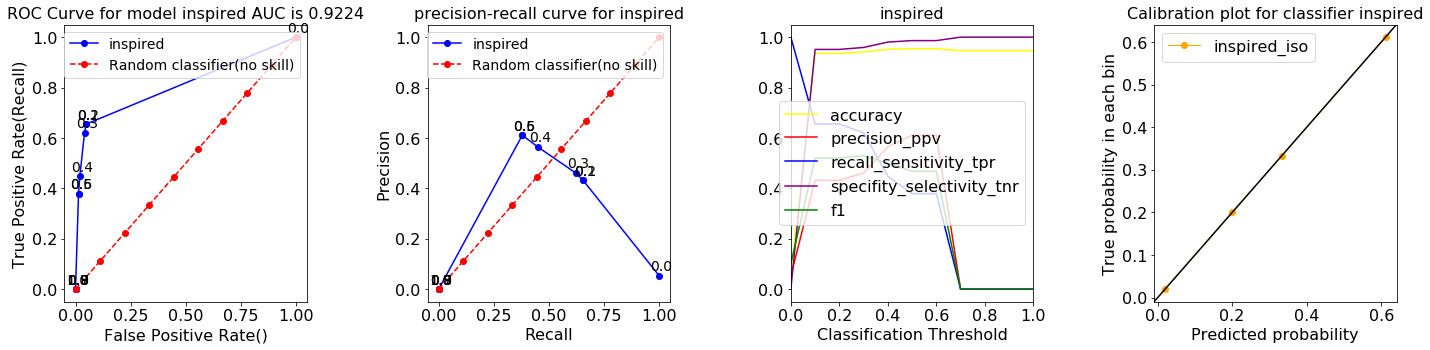

Max evaluation metric for model inspired
* Accuracy:  0.9539594843462247 at threshold  0.5
* Precision:  0.6111111111111112 at threshold  0.5
* Recall:  1.0 at threshold  0.0
* F1:  0.5294117647058824 at threshold  0.3
* ROC-AUC 0.9224
* Log Loss 0.12321700429124544



Metrics for market per Classification Threshold


,model,threshold,tp,fp,tn,fn,accuracy,precision_ppv,recall_sensitivity_tpr,f1,f2,f0_5,specifity_selectivity_tnr,tpr,fpr
0,market,0.0,54,489,0,0,0.0994475,0.0994475,1,0.180905,0.355731,0.121294,0,1,1
1,market,0.1,47,101,388,7,0.801105,0.317568,0.87037,0.465347,0.645604,0.363777,0.793456,0.87037,0.206544
2,market,0.2,34,21,468,20,0.924494,0.618182,0.62963,0.623853,0.627306,0.620438,0.957055,0.62963,0.0429448
3,market,0.3,34,21,468,20,0.924494,0.618182,0.62963,0.623853,0.627306,0.620438,0.957055,0.62963,0.0429448
4,market,0.4,34,21,468,20,0.924494,0.618182,0.62963,0.623853,0.627306,0.620438,0.957055,0.62963,0.0429448
5,market,0.5,24,6,483,30,0.933702,0.8,0.444444,0.571429,0.487805,0.689655,0.98773,0.444444,0.0122699
6,market,0.6,23,5,484,31,0.933702,0.821429,0.425926,0.560976,0.471311,0.692771,0.989775,0.425926,0.0102249
7,market,0.7,20,3,486,34,0.93186,0.869565,0.37037,0.519481,0.41841,0.684932,0.993865,0.37037,0.00613497
8,market,0.8,20,3,486,34,0.93186,0.869565,0.37037,0.519481,0.41841,0.684932,0.993865,0.37037,0.00613497
9,market,0.9,8,0,489,46,0.915285,1,0.148148,0.258065,0.178571,0.465116,1,0.148148,0


<Figure size 432x288 with 0 Axes>

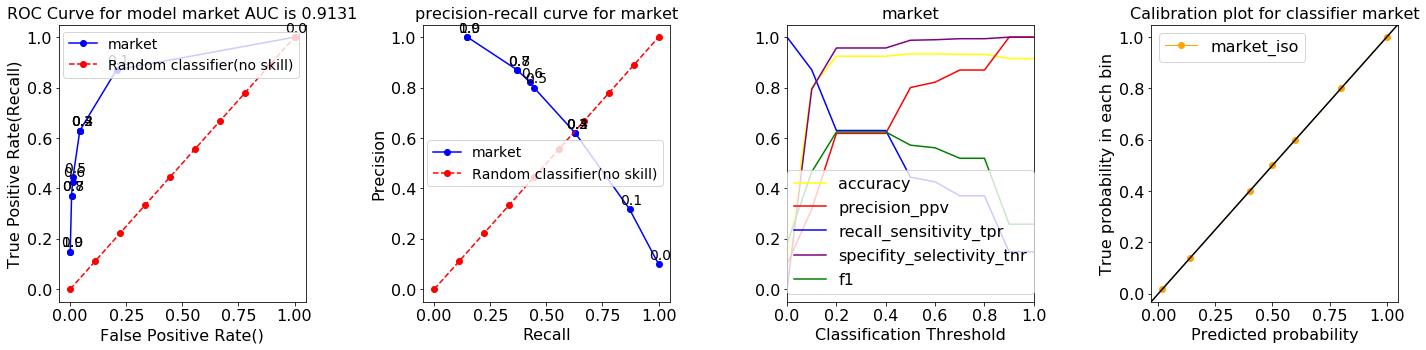

Max evaluation metric for model market
* Accuracy:  0.9337016574585635 at threshold  0.5
* Precision:  1.0 at threshold  0.9
* Recall:  1.0 at threshold  0.0
* F1:  0.6238532110091743 at threshold  0.2
* ROC-AUC 0.9131
* Log Loss 0.17951134798722457



Metrics for project per Classification Threshold


,model,threshold,tp,fp,tn,fn,accuracy,precision_ppv,recall_sensitivity_tpr,f1,f2,f0_5,specifity_selectivity_tnr,tpr,fpr
0,project,0.0,70,473,0,0,0.128913,0.128913,1,0.228385,0.425273,0.156111,0,1,1
1,project,0.1,67,170,303,3,0.6814,0.2827,0.957143,0.436482,0.647969,0.329077,0.640592,0.957143,0.359408
2,project,0.2,58,104,369,12,0.786372,0.358025,0.828571,0.5,0.656109,0.4039,0.780127,0.828571,0.219873
3,project,0.3,37,37,436,33,0.871087,0.5,0.528571,0.513889,0.522599,0.505464,0.921776,0.528571,0.0782241
4,project,0.4,37,37,436,33,0.871087,0.5,0.528571,0.513889,0.522599,0.505464,0.921776,0.528571,0.0782241
5,project,0.5,6,2,471,64,0.878453,0.75,0.0857143,0.153846,0.104167,0.294118,0.995772,0.0857143,0.00422833
6,project,0.6,4,0,473,66,0.878453,1,0.0571429,0.108108,0.0704225,0.232558,1,0.0571429,0
7,project,0.7,4,0,473,66,0.878453,1,0.0571429,0.108108,0.0704225,0.232558,1,0.0571429,0
8,project,0.8,4,0,473,66,0.878453,1,0.0571429,0.108108,0.0704225,0.232558,1,0.0571429,0
9,project,0.9,4,0,473,66,0.878453,1,0.0571429,0.108108,0.0704225,0.232558,1,0.0571429,0


<Figure size 432x288 with 0 Axes>

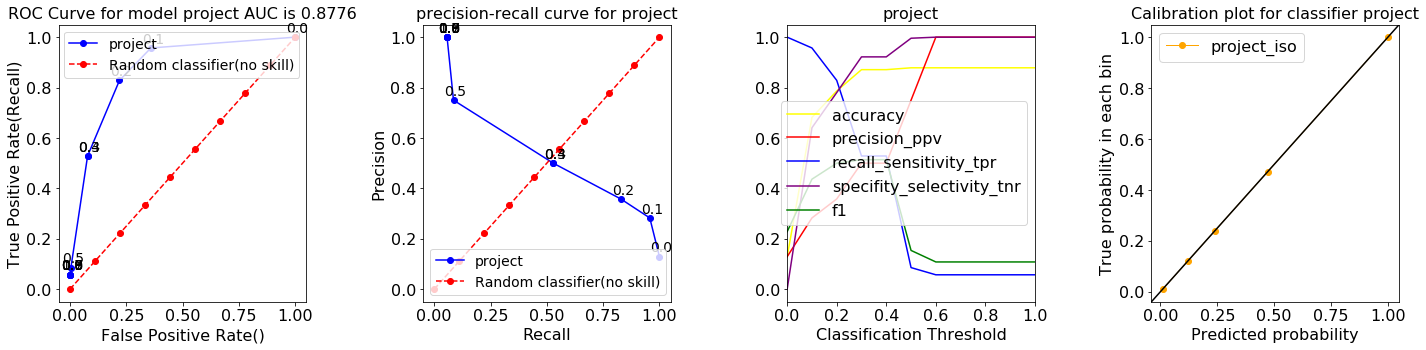

Max evaluation metric for model project
* Accuracy:  0.8784530386740331 at threshold  0.5
* Precision:  1.0 at threshold  0.6
* Recall:  1.0 at threshold  0.0
* F1:  0.513888888888889 at threshold  0.3
* ROC-AUC 0.8776
* Log Loss 0.25767004013323497



Metrics for renown per Classification Threshold


,model,threshold,tp,fp,tn,fn,accuracy,precision_ppv,recall_sensitivity_tpr,f1,f2,f0_5,specifity_selectivity_tnr,tpr,fpr
0,renown,0.0,29,514,0,0,0.053407,0.053407,1,0.101399,0.22003,0.0658791,0,1,1
1,renown,0.1,19,40,474,10,0.907919,0.322034,0.655172,0.431818,0.542857,0.358491,0.922179,0.655172,0.077821
2,renown,0.2,18,32,482,11,0.92081,0.36,0.62069,0.455696,0.542169,0.393013,0.937743,0.62069,0.0622568
3,renown,0.3,10,5,509,19,0.955801,0.666667,0.344828,0.454545,0.381679,0.561798,0.990272,0.344828,0.00972763
4,renown,0.4,10,5,509,19,0.955801,0.666667,0.344828,0.454545,0.381679,0.561798,0.990272,0.344828,0.00972763
5,renown,0.5,10,5,509,19,0.955801,0.666667,0.344828,0.454545,0.381679,0.561798,0.990272,0.344828,0.00972763
6,renown,0.6,6,2,512,23,0.953959,0.75,0.206897,0.324324,0.241935,0.491803,0.996109,0.206897,0.00389105
7,renown,0.7,6,2,512,23,0.953959,0.75,0.206897,0.324324,0.241935,0.491803,0.996109,0.206897,0.00389105
8,renown,0.8,1,0,514,28,0.948435,1,0.0344828,0.0666667,0.042735,0.151515,1,0.0344828,0
9,renown,0.9,1,0,514,28,0.948435,1,0.0344828,0.0666667,0.042735,0.151515,1,0.0344828,0


<Figure size 432x288 with 0 Axes>

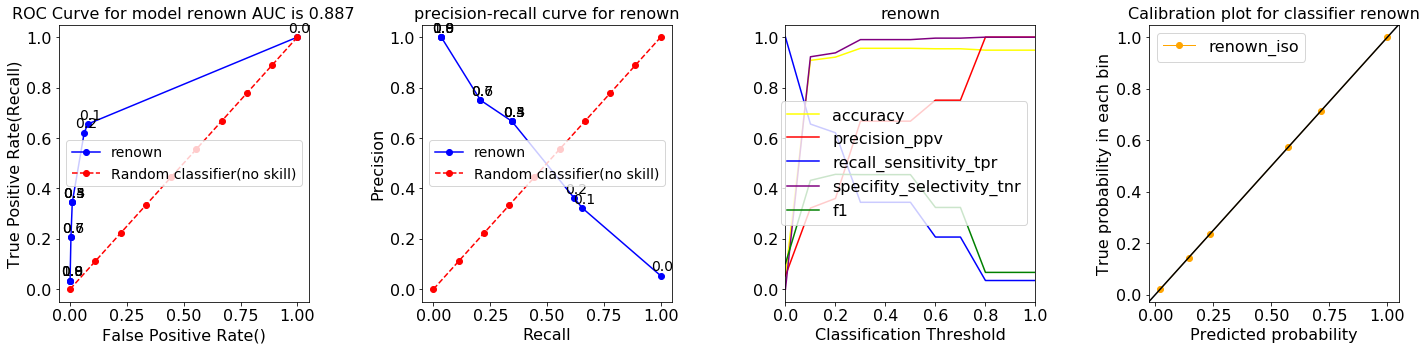

Max evaluation metric for model renown
* Accuracy:  0.9558011049723757 at threshold  0.3
* Precision:  1.0 at threshold  0.8
* Recall:  1.0 at threshold  0.0
* F1:  0.45569620253164556 at threshold  0.2
* ROC-AUC 0.887
* Log Loss 0.1368373891929042


<Figure size 432x288 with 0 Axes>

In [155]:
def review_model_metrics(validation_data, _DLModels, _DLModelsIsotonicRegression, _DLData_val_x_txt_seq, _DLData_val_x_txt, _DLData_val_y, combined_data ):
    #Generate a list of 100 possible tresholds between 0 and .96, 
    # AF why .96?
    #thresholds = np.linspace(0,0.96,100)
    #thresholds = np.linspace(0,1,10)
    #AF: We could evaluate thresholds from 0.0 to 1.0 in increments of 0.1?
    thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    tn_list = []
    fp_list = [] 
    fn_list = []
    tp_list = []

    dict_opt_f1_threshold = {}
    dict_opt_precision_threshold = {}
    dict_opt_recall_threshold = {}
    dict_opt_accuracy_threshold = {}
    dict_roc_auc = {}
    dict_log_loss = {}

    SMALL_SIZE = 8
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 16



    metrics_for_all = pd.DataFrame()

    # AF: at each step calculating the precision, recall, F1, and location on the ROC curve. 
    #For each convention
    for k in _DLModels.keys():
        tn_list = []
        fp_list = [] 
        fn_list = []
        tp_list = []

        #get the model, the validation data input(data_x) and the predicted label(y_predict) to compare to the actual label(y_actual).
        my_model = _DLModels[k]
        my_ir = _DLModelsIsotonicRegression[k]
        
        
        if (combined_data == False):
            print("using individual flow")
            #show the reliability and calibrate with the seperated balanced data
            data_x = _DLData_val_x_txt_seq[k]
            y_actual = [int(x[0]<x[1]) for x in _DLData_val_y[k]]
            
            #Predict with the base model from the BR se, this returns [0][1]
            
        
        elif (combined_data == True):
            #show the reliability and calibrate with the combined unbalanced data
            data_x, y_actual = get_X_y_from_combined_pd(validation_data, k)
            

        
        y_predict = my_model.predict(data_x)
        #obtain from the response the scores for value = 1(True) 
        pos_predict_prob = get_positive_preds_probabilities(y_predict)
    
        #input the scores for value = 1(True) to the fitted isotonic regressor for model in question
        y_predict_isotonic = my_ir.predict(pos_predict_prob)

        #Use the calibrated predictions probabilities moving forward
        pos_predict_prob = y_predict_isotonic.copy() 


        dict_roc_auc[k] = roc_auc_score(y_actual ,pos_predict_prob).round(4)
        dict_log_loss[k] = log_loss(y_actual , pos_predict_prob, eps = 1e-7 )
    
    
        for t in thresholds:
            y_pred = get_positive_preds_with_threshold(pos_predict_prob, t)
            confusion_matrix = metrics.confusion_matrix(y_actual, y_pred)
            tn, fp, fn, tp = confusion_matrix.ravel()
            tn_list.append(tn)
            fp_list.append(fp)
            fn_list.append(fn)
            tp_list.append(tp)
        print ("")
        display (HTML("<font color = green><h3><left>*** " + k + "***</left></h3></font>"))
        results_for_current_convention = pd.DataFrame({'threshold': thresholds,
                            'tp': tp_list,
                            'fp': fp_list,
                            'tn': tn_list,
                            'fn': fn_list
                           })
   
        metrics_df =  calculate_metrics(results_for_current_convention, len(y_actual), k);
        print("Metrics for " +k + " per Classification Threshold")
        display(metrics_df)
        metrics_for_all = pd.concat([metrics_for_all,metrics_df], sort = False)
    
        plt.figure(figsize=(20,5))
        plt.style.use('seaborn-dark-palette')
        plt.rc('font', size =MEDIUM_SIZE )                  # controls default text sizes
        plt.rc('axes', titlesize=BIGGER_SIZE)   # fontsize of the axes title
        plt.rc('axes', labelsize=BIGGER_SIZE)   # fontsize of the x and y labels
        plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
        plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
        
        ax1 = plt.subplot(1, 4, 1)
        my_thresholds = [str(t) for t in metrics_df['threshold']]
        ax1.plot(metrics_df['fpr'], metrics_df['tpr'], 'bo-', label = k);
        ax1.plot(list(np.linspace(0, 1, num = 10)), list(np.linspace(0, 1, num = 10)), 'ro--', label = 'Random classifier(no skill)');
        for x, y, s in zip(metrics_df['fpr'], metrics_df['tpr'], my_thresholds):
            ax1.text(x - 0.04,y + 0.02, s, fontdict={'size': 14});
        ax1.legend(prop={'size':14})
        ax1.set_ylabel('True Positive Rate(Recall)'); 
        ax1.set_xlabel('False Positive Rate()');
        ax1.set_title('ROC Curve for model '+k + " AUC is " + str(dict_roc_auc[k]))
        #plt.show()
        #plt.clf()
    

        ax2 = plt.subplot(1, 4, 2)
        ax2.plot(metrics_df['recall_sensitivity_tpr'], metrics_df['precision_ppv'], 'bo-', label = k);
        ax2.plot(list(np.linspace(0, 1, num = 10)), list(np.linspace(0, 1, num = 10)), 'ro--', label = 'Random classifier(no skill)');
        for x, y, s in zip(metrics_df['recall_sensitivity_tpr'], metrics_df['precision_ppv'], my_thresholds):
            ax2.text(x - 0.04,y + 0.02, s, fontdict={'size': 14});
        ax2.legend(prop={'size':14})
        ax2.set_ylabel('Precision'); plt.xlabel('Recall');
        ax2.set_title('precision-recall curve for '+k )
        #plt.show()
        #plt.clf()
    
        ax3 = plt.subplot(1, 4, 3)
        ax3 = plt.gca()
        ax3.set_title(k)
        metrics_df.plot(kind='line',x='threshold',y='accuracy', color='yellow',ax=ax3)
        metrics_df.plot(kind='line',x='threshold',y='precision_ppv', color='red', ax=ax3)
        metrics_df.plot(kind='line',x='threshold',y='recall_sensitivity_tpr', color='blue',ax=ax3)
        metrics_df.plot(kind='line',x='threshold',y='specifity_selectivity_tnr', color='purple',ax=ax3)
        metrics_df.plot(kind='line',x='threshold',y='f1', color='green', ax=ax3)
        ax3.set_xlabel('Classification Threshold')
        
        
        ax4 = plt.subplot(1, 4, 4)
        #plot the calibration curve just to confirm the calibration
        y_iso, x_iso = calibration_curve(y_actual, pos_predict_prob, n_bins=10);
        _ = plt.rcParams.update({'font.size': 11})
        _ = plt.rcParams.update({'font.weight': 'normal'})
        _ = plt.plot(x_iso, y_iso, marker='o', linewidth=1, label=k+'_iso', color='orange');
        # reference line, legends, and axis labels
        line = mlines.Line2D([0, 1], [0, 1], color='black')
        transform = ax4.transAxes
        _ = line.set_transform(transform)
        _ = ax4.add_line(line)
        ax4.set_title ('Calibration plot for classifier ' + k) 
        _ = ax4.set_xlabel('Predicted probability')
        _ = ax4.set_ylabel('True probability in each bin')
        _ = plt.legend()
    ####################################################################
        plt.tight_layout()
        plt.show()
        plt.clf()
        print ("Max evaluation metric for model", k)

        best = metrics_df[['recall_sensitivity_tpr','precision_ppv', 'f1', 'accuracy']].max()
        try:
            best_precision_threshold = metrics_df[['threshold']][metrics_df.precision_ppv == best[1]]['threshold'].iloc[0]
        except:
            best_precision_threshold = metrics_df[['threshold']][metrics_df.precision_ppv == best[1]]['threshold'] 
    
        try:
            best_recall_threshold = metrics_df[['threshold']][metrics_df.recall_sensitivity_tpr == best[0]]['threshold'].iloc[0]     
        except:
            best_recall_threshold = metrics_df[['threshold']][metrics_df.recall_sensitivity_tpr == best[0]]['threshold']
    
        try:
            best_F1_threshold = metrics_df[['threshold']][metrics_df.f1 == best[2]]['threshold'].iloc[0] 
        except:
            best_F1_threshold = metrics_df[['threshold']][metrics_df.f1 == best[2]]['threshold']
        
        try:
            best_accuracy_threshold = metrics_df[['threshold']][metrics_df.accuracy == best[3]]['threshold'].iloc[0] 
        except:
            best_accuracy_threshold = metrics_df[['threshold']][metrics_df.accuracy == best[3]]['threshold']
   
        dict_opt_f1_threshold[k] = best_F1_threshold
        dict_opt_precision_threshold[k] = best_precision_threshold
        dict_opt_recall_threshold[k]  =  best_recall_threshold
        dict_opt_accuracy_threshold[k]  =  best_accuracy_threshold
        print ("* Accuracy: ", best [3], "at threshold ", best_accuracy_threshold)
        print ("* Precision: ", best [1], "at threshold ", best_precision_threshold)
        print ("* Recall: ", best [0], "at threshold ", best_recall_threshold)
        print ("* F1: ", best [2], "at threshold ", best_F1_threshold)
        print ("* ROC-AUC", dict_roc_auc[k])
        print ("* Log Loss",dict_log_loss[k])

    gc.collect()


    metrics_for_all = metrics_for_all.reset_index().drop("index",  axis=1)
    return metrics_for_all, dict_roc_auc

#metrics_for_all, dict_roc_auc = review_model_metrics(None, _DLModels, _DLModelsIsotonicRegression, _DLData_val_x_txt_seq, _DLData_val_x_txt, _DLData_val_y, combined_data = False )
metrics_for_all, dict_roc_auc = review_model_metrics(validation_data_pos_from_models, _DLModels, _DLModelsIsotonicRegression, _DLData_val_x_txt_seq, _DLData_val_x_txt, _DLData_val_y, combined_data = True )
#all the combined data but using the calibration trained on the individual data
#metrics_for_all = review_model_metrics(validation_data_pos_from_models, _DLModels, _DLModelsIsotonicRegression, _DLData_val_x_txt_seq, _DLData_val_x_txt, _DLData_val_y, combined_data = True )


# Further Metrics analysis for selection of Threshold

In [197]:
accuracyHTML = HTML('<b>Accuracy = (TP + TN)/(TP + FP + TN + FN)</b> <br/>The probability that the classification result is correct, ie probability of correctly labelling sentences as class 1 or Class 0, given all the sentences! Accuracy is simply the ratio of the correctly labeled sentences out of all sentences. Good measure with balanced data and when false positive and false negative have a similar “cost”')
precisionHTML = HTML('<b>Precision or Positive prediction value =  TP / (TP + FP)</b> <br/>The probability that a sentences we have labeled as Class 1(belonging to the convention) is actually Class 1. Our focus in terms of performance might be on correctly identifying positive cases, i.e to maximise the "precision". Although a model with unbalanced data could also "cheat" and maximise this by always returning “negative”. This metric is important if the most important function of the model will be to identify positives (Class 1). If this is a priority then we should choose a model with higher Recall/Sensitivity.')
recallHTML = HTML('<b>Recall or Sensitivity or TPR =  TP / (TP + FN)</b><br/>Given the sentence is part of the convention, how likely is it that the classification will be positive? Our focus then in terms of performance could maybe be in terms of higher importance on identifying the positive cases, i.e to maximise the "recall" or "sensitivity". Although a model could also "cheat" and maximise this by always returning “positive”. This metric is important if the most important function of the model will be to identify positives (Class 1). If this is most important to us then we should choose a model with higher Recall/Sensitivity.')
specificityHTML = HTML('<b> Specificity or TNR = TN / (TN + FP)</b><br/>How good a classifier is at avoiding false alarms. Given the sentence does not belong to the convention, how likely is it that the classification will be negative(class 0). If correctly identifying negatives is most important, then we should choose specificity as the measurement metric. A classifier can "cheat" and maximise this by always returning “negative” Class 0.')
F_scoreHTML = HTML('<b>F1 =  2 * ( (Precision * Recall) / (Precision + Recall)) or Fi = (1 + i^2) * ( (precision * recall) / (i^2 * (Precision + Recall)</b><br/>If we want to find an optimal blend of precision and recall we can combine the two metrics using what is called the F-score, this is the harmonic mean of precision and recall (harmonic mean is used as it punishes extreme values). Note: there are other F measures: <br/>* F2 which weights recall higher than precision<br/>* F0.5 which puts more emphasis on precision than recall.')
metricsGenHTML = HTML("If correctly identifying positives is important for us, then we should choose a model with higher Recall/Sensitivity. <br/>If correctly identifying negatives is more important, then we should choose higher precision/specificity as the measurement metric.")

my_style = {'description_width': 'initial'}
my_layout = {'width': '600px'}
my_layout_short = {'width': '400px'}
my_layout_shortest = {'width': '250px'}
space = widgets.Label(' ', layout=widgets.Layout(width='10%'))

classifier_thresholds = {}
dic_threshold_manual = {}
threshold_best_all = metrics_for_all.head(1).copy()
threshold_manual_all = metrics_for_all.head(1).copy()
threshold_t_calab_all = metrics_for_all.head(1).copy()

global_pos_validation_df = pd.DataFrame()
convention_list = []


metrics_list = ['accuracy', 'precision_ppv', 'recall_sensitivity_tpr',
                'f1', 'f2', 'f0_5', 'specifity_selectivity_tnr']


metric_drop_down = widgets.Dropdown(
    options=metrics_list,
    value=metrics_list[0],
    description='Review Metric  :',
    disabled=False,
    style=my_style,
    layout=my_layout
)

use_metric_drop_down = widgets.Dropdown(
    options=["--select--", "max value", "T calab", "Manually set"],
    value="--select--",
    description='Select tresholds to generate results :',
    disabled=False,
    style=my_style,
    layout=my_layout
)


# Plot the precision v's the classification treshold for all models. This is plotting at which threshold each classifier
# meets a minimum precision score.
confidence_goal_slider = widgets.FloatSlider(
    min=0,
    max=1,
    value=.8,
    step=0.1,
    description='Score:',
    style=my_style,
    layout=my_layout
)

confidence_goal_slider.style.handle_color = '#5c85d6'


def get_manual_threshold(civic, domestic, green, industrial, inspired, market, project, renown):
    global dic_threshold_manual
    global metrics_for_all
    global threshold_manual_all
    
    threshold_manual_all = metrics_for_all.head(1).copy()
    threshold_man = metrics_for_all.head(1).copy()
    dic_threshold_manual = {}
    try:
        for k in _DLModels.keys():
            dic_threshold_manual[k] = dict_manual_sliders[k].value
            threshold_man = metrics_for_all[(metrics_for_all.model == k) & (metrics_for_all['threshold'] == dic_threshold_manual[k])].iloc[0].to_frame().transpose()
            threshold_manual_all = pd.concat([threshold_manual_all, threshold_man], sort=False)
        threshold_manual_all = threshold_manual_all.reset_index().drop('index', axis=1).drop(0)
        display(threshold_manual_all)
    except:
        return

# \\\\\\\
# micro = threshold_t_calab_all[['tp', 'fp', 'tn', 'fn']].sum(axis=0)
#     tp_t = micro[0]
#     fp_t = micro[1]
#     tn_t = micro[2]
#     fn_t = micro[3]
#     micro_ave_df = calculate_full_set_micro_average([tp_t, fp_t, tn_t, fn_t])
#     threshold_t_calab_all = pd.concat(
#         [threshold_t_calab_all, micro_ave_df], sort=False)
#     threshold_t_calab_all = threshold_t_calab_all.reset_index().drop('index', axis=1)
# \\\\\\\\
dict_manual_sliders = {}
list1 = []
list2 = []
for k in _DLModels.keys():
    dict_manual_sliders[k] = widgets.FloatSlider(
        min=0, max=1, value=0.5, step=0.1, description=k, style=my_style, layout=my_layout_short)
    dict_manual_sliders[k].style.handle_color = '#5c85d6'
    list1.append(dict_manual_sliders[k])

manual_out = widgets.interactive_output(get_manual_threshold, dict_manual_sliders)


cut = int(len(list1)/2)
for x in range(cut):
    list2.append(list1.pop(x))
manual_sliders = widgets.HBox(
    [widgets.VBox(list2),
     space,
     widgets.VBox(list1)
     ])


selectSettingForCoOccurHTML = widgets.HTML(
    "<font color = '#8c8c8c'><h1><center>***  Generate co-occurance matrix   ***</center></h1></font>")

headingHTML = widgets.HTML(
    "<font color = '#8c8c8c'><h1><center>***  View Evaluation Metrics   ***</center></h1></font>")

output_metrics_info = widgets.Output()


def results_output_function(use_metric_drop_down_value):
    global threshold_best_all
    global threshold_t_calab_all
    global _DLModels
    global global_pos_validation_df
    global _DLModelsIsotonicRegression
    global global_final_threshold
    global global_final_results_df
    global dic_threshold_manual

    thresholds = {}
    if use_metric_drop_down_value == "--select--":
        # with results_output:
        clear_output(wait=True)
        print("Select from dropdown to generate analysis")
        return
    for k in _DLModels.keys():
        try:
            if use_metric_drop_down_value == "max value":
                threshold = threshold_best_all[threshold_best_all.model == k]['threshold'].iloc[0]
                thresholds[k] = threshold
            if use_metric_drop_down_value == "T calab":
                threshold = threshold_t_calab_all[threshold_t_calab_all.model == k]['threshold'].iloc[0]
                thresholds[k] = threshold

            if use_metric_drop_down_value == "Manually set":
                threshold = dic_threshold_manual[k]
                thresholds[k] = threshold
        except:
            print("No entry for: ", k)

    print(thresholds)

    def my_inner_funct(validation_df):
        _ = plt.clf()
        co_occur_list = []
        rename = []
        all_validation_df = pd.DataFrame()
        all_validation_df = validation_df.copy()
        plt.figure(figsize=(18, 6))
        plt.style.use('seaborn-dark-palette')

        for x in all_validation_df.columns.values:
            if x.endswith(('_y_pred')):
                co_occur_list.append(x)
                rename.append(x.replace('_y_pred', ''))
        y_actual_list = rename
        co_occur_y_predict = all_validation_df[co_occur_list].copy()
        co_occur_y_actual = all_validation_df[y_actual_list].copy()

        for old, x in zip(co_occur_list, range(len(co_occur_list))):
            co_occur_y_predict = co_occur_y_predict.rename(
                columns={old: rename[x]})

        text = "Predicted Co-occurance Matrix with Predicted and Actual Cardinality "
        display(HTML("<font color = green><h3><left>" +
                     text + "</left></h3></font>"))
        ax1 = plt.subplot(1, 3, 1)
        ax1 = model_helpers.co_occurance_matrix(co_occur_y_predict)

        ax2 = plt.subplot(1, 3, 2)
        ax2 = model_helpers.label_cardinality_bar(
            co_occur_y_predict, title="Predicted Cardinality")

        ax3 = plt.subplot(1, 3, 3)
        ax3 = model_helpers.label_cardinality_bar(
            co_occur_y_actual, title="Actual Cardinality")
        
        plt.show()
        

       
        

#     all_validation_df = process_validation_data(thresholds,
#                                                 _DLModels,
#                                                 _DLData_val_x_txt_seq,
#                                                 _DLData_val_x_txt,
#                                                 _DLData_val_y,
#                                                 _DLModelsIsotonicRegression,
#                                                 predict = True,
#                                                 pos_only = False)

    all_validation_df, thresholds_used = process_validation_data(thresholds,
                                                                 _DLModels,
                                                                 _DLData_val_x_txt_seq,
                                                                 _DLData_val_x_txt,
                                                                 _DLData_val_y,
                                                                 _DLModelsIsotonicRegression,
                                                                 predict=True,
                                                                 pos_only=True)

    my_inner_funct(all_validation_df)
    display(get_count(all_validation_df, _DLModels, thresholds_used, num_prob_buckets = 8, actual=True ))
    
    
    # setting two global values we may want to use outside of the method
    global_final_threshold = thresholds_used
    global_final_results_df = all_validation_df
    print("Final tresholds are stored in global variable 'global_final_threshold'")
    print("Final prediction results are stored in global variable 'global_final_results_df'")


def output_function(metric_drop_down_value, confidence_goal_slider_value):
    global thresholds
    global metrics_for_all
    global threshold_best_all
    global threshold_t_calab_all
    global _DLModels
    global classifier_thresholds
    global output_metrics_info
    global _DLModelsIsotonicRegression
    classifier_thresholds = {}
    threshold_best_all = metrics_for_all.head(1).copy()
    threshold_t_calab_all = metrics_for_all.head(1).copy()


    with output_metrics_info:
        clear_output(wait=True)
        if metric_drop_down_value == 'accuracy':
            display(accuracyHTML)
        if metric_drop_down_value == 'precision_ppv':
            display(precisionHTML)
        if metric_drop_down_value == 'recall_sensitivity_tpr':
            display(recallHTML)
        if metric_drop_down_value == 'specifity_selectivity_tnr':
            display(specificityHTML)
        if metric_drop_down_value == 'f1':
            display(F_scoreHTML)
        if metric_drop_down_value == 'f2':
            display(F_scoreHTML)
        if metric_drop_down_value == 'f0_5':
            display(F_scoreHTML)
        display(metricsGenHTML)

    plt.figure(figsize=(10, 7))

    performance_goal = confidence_goal_slider_value
    metric = metric_drop_down_value
    auc = []
    auc_t_calab = []

    for k in _DLModels.keys():
        x = thresholds
        y = metrics_for_all[metrics_for_all.model == k][metric].to_numpy()
        plt.plot(x, y, marker='', linewidth=2, linestyle='dashed', label=k.capitalize()+" model")
        t_index = None
        try:
            t_index = np.argwhere(y > performance_goal)[0]
        except:
            pass
        if t_index is not None:
            classifier_thresholds[k] = x[t_index[0]]
            thresh = x[t_index[0]]
            auc_t_calab.append(dict_roc_auc[k])
            threshold_t_calab = metrics_for_all[(metrics_for_all.model == k) & (metrics_for_all['threshold'] == thresh)].iloc[0].to_frame().transpose()
            threshold_t_calab_all = pd.concat([threshold_t_calab_all, threshold_t_calab], sort=False)

        auc.append(dict_roc_auc[k])
        best = metrics_for_all[metrics_for_all.model == k][metric].max()
        threshold_best = metrics_for_all[(metrics_for_all.model == k) & (metrics_for_all[metric] == best)].iloc[0].to_frame().transpose()
        threshold_best_all = pd.concat([threshold_best_all, threshold_best], sort=False)
        

        
    threshold_best_all = threshold_best_all.reset_index().drop('index', axis=1).drop(0)
    threshold_t_calab_all = threshold_t_calab_all.reset_index().drop('index', axis=1).drop(0)
   
    # Declare a list that is to be converted into a column

    threshold_best_all['auc'] = auc
    threshold_t_calab_all['auc'] = auc_t_calab

    micro = threshold_best_all[['tp', 'fp', 'tn', 'fn']].sum(axis=0)
    tp = micro[0]
    fp = micro[1]
    tn = micro[2]
    fn = micro[3]
    micro_ave_df = calculate_full_set_micro_average([tp, fp, tn, fn])
    threshold_best_all = pd.concat(
        [threshold_best_all, micro_ave_df], sort=False)
    threshold_best_all = threshold_best_all.reset_index().drop('index', axis=1)

    micro = threshold_t_calab_all[['tp', 'fp', 'tn', 'fn']].sum(axis=0)
    tp_t = micro[0]
    fp_t = micro[1]
    tn_t = micro[2]
    fn_t = micro[3]
    micro_ave_df = calculate_full_set_micro_average([tp_t, fp_t, tn_t, fn_t])
    threshold_t_calab_all = pd.concat(
        [threshold_t_calab_all, micro_ave_df], sort=False)
    threshold_t_calab_all = threshold_t_calab_all.reset_index().drop('index', axis=1)

    #plt.title("Comparing precission scores for all classifiers", fontdict={'fontsize':20}, pad=25)
    plt.xlabel("Confidence threshold ($T_{calibration}$)", fontsize=14)
    plt.ylabel(metric + " score", fontsize=14)
    plt.hlines(y=performance_goal, xmin=0, xmax=1.00001,
               color='black', linestyle=":", lw=4, label="$T_{precision}$")
    plt.legend(fontsize=15, bbox_to_anchor=(1.01, 1.01))
    plt.show()
    plt.clf()
    gc.collect()

    display(HTML("<font color = green><h3><left>Evaluation Metrics summary per model:</left></h3></font>"))
    text = "Using probability/Classification Threshold based on T calab for " + metric
    display(HTML("<font color = green><h4><left>" + text + "</left></h4></font>"))
    display(threshold_t_calab_all)
    display(HTML("To measure a multi-class classifier we have to average out the classes somehow. There are two different methods of doing this called micro-averaging and macro-averaging.<br/> * In micro-averaging all TPs, TNs, FPs and FNs for each class are summed up and then the average is taken.<br/>* Macro-averaging is just the average of the precision and recall of the system on different sets"))
    print("")
    print("")
    text = "Using Probability/Classification Threshold based on max " + metric
    display(HTML("<font color = green><h4><left>" + text + "</left></h4></font>"))
    display(threshold_best_all)
    print("")
    print("")
    text = "Using Probability/Classification Threshold based on manual selection of the Thresholds"
    display(HTML("<font color = green><h4><left>" + text + "</left></h4></font>"))

    display(manual_sliders)
    use_metric_drop_down.value = "--select--"


main_output = widgets.interactive_output(output_function, {
    'metric_drop_down_value': metric_drop_down,
    'confidence_goal_slider_value': confidence_goal_slider
})

results_output = widgets.interactive_output(results_output_function, {
    'use_metric_drop_down_value': use_metric_drop_down
})



display(headingHTML,
        metric_drop_down,
        output_metrics_info,
        confidence_goal_slider,
        main_output,
        manual_out,
        selectSettingForCoOccurHTML,
        use_metric_drop_down,
        results_output)


# https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c
# AF:  whert is the equalized_precisions_threshold set?

HTML(value="<font color = '#8c8c8c'><h1><center>***  View Evaluation Metrics   ***</center></h1></font>")

Dropdown(description='Review Metric  :', layout=Layout(width='600px'), options=('accuracy', 'precision_ppv', '…

Output()

FloatSlider(value=0.8, description='Score:', layout=Layout(width='600px'), max=1.0, style=SliderStyle(descript…

Output()

Output()

HTML(value="<font color = '#8c8c8c'><h1><center>***  Generate co-occurance matrix   ***</center></h1></font>")

Dropdown(description='Select tresholds to generate results :', layout=Layout(width='600px'), options=('--selec…

Output()

In [199]:
def print_me (global_final_results_df):
        plt.clf()
        all_validation_df = global_final_results_df
        for conv in _DLModels.keys():
            fig = px.bar(all_validation_df, x='lbl_cnt', y=conv, color=conv+'_y_pred',height=300)
            fig.update_layout(barmode='stack', title_text=conv+' TP and FN per cardinality',yaxis={'categoryorder':'total descending'} )#stack
            fig.show()
print_me (global_final_results_df)

<Figure size 432x288 with 0 Axes>

# Review some of the co-occuring sentences, set the firist var "label count" to between 2 and 8 to review co-occurances

In [ ]:
label_count = 4

print (thresholds_calab)
#print (thresholds_max)

# # used this to validate the calculations.
# #print(metrics.classification_report(y_actual, y_pred, digits=3))
view_co_occur = widgets.SelectMultiple(
     options=thresholds_calab,
     #rows=10,
     description='select co-occurences to view',
     disabled=False,
     style = my_style,
     layout = my_layout
 )

# output_review_txt = widgets.Output()
# def view_co_occurances():
#     return


# row_to_edit = convention_sentences_df.loc[(convention_sentences_df[convention_drop_down_value] == 1) &
#                                             (convention_sentences_df['data_provenance'] == source_drop_down_value) &
#                                             (convention_sentences_df['confidence_value'] >= filter_lower) &
#                                             (convention_sentences_df['confidence_value'] <= filter_upper)].sample(n = 1)

display (global_final_results_df.shape[0])

temp = global_final_results_df.loc[(global_final_results_df['lbl_cnt'] == label_count)]
for x in range (20):
    print ("Text to be classified:")
    display (temp.iloc[x][0])
    print ("The actual conventions:")
    for k in thresholds_calab:
        if temp.iloc[x][k] == 1:
            print (k+" actual",temp.iloc[x][k])
            print (k+" predicted",temp.iloc[x][k+"_y_pred"])
            print (k+" probability/confidence of prediction",temp.iloc[x][k+"_prob"])
    print ("")
    print ("The false positives conventions:")
    for k in thresholds_calab:
        if temp.iloc[x][k+"_y_pred"] == 1 and temp.iloc[x][k] == 0:
            #print (k+" actual",temp.iloc[x][k])
            print (k+" predicted",temp.iloc[x][k+"_y_pred"])
            print (k+" probability/confidence of prediction",temp.iloc[x][k+"_prob"])
    print ("")
    print ("The false negative conventions:")
    for k in thresholds_calab:
        if temp.iloc[x][k+"_y_pred"] == 0 and temp.iloc[x][k] == 1:
            print (k+" actual",temp.iloc[x][k])
            print (k+" predicted",temp.iloc[x][k+"_y_pred"])
            print (k+" probability/confidence of prediction",temp.iloc[x][k+"_prob"])
       
       
    print ("############") 
    print ("")


# Note that at this point we have a validation DataFrame with:
- One row per unique sentence
- y_actual in column {model)
- The true/false y_predicted of each individual calibrated model in {model}_y_pred
- The probability confidence score of y_pred whether 0 or 1 in {model}_prob
- The probability confidence score of True(1) in {model}_prob_1
- The Set confidence of entire model set (in column 'set_conf'), calculated as the sum of the individual {model}_y_pred confidences. 
- The per sentence cardinality, across entire model set (in column 'lbl_cnt')

There are two types of confidence scores in BR: 
     * The confidence of an individual label prediction p(yl|x)
     * The confidence of the entire predicted set p(y|x). 

A natural requirement in many end-use applications is that the classifier provides a well-calibrated confidence (probability) to indicate the likelihood of the predicted set being correct; for example, an application may automate high-confidence predictions while manually verifying low-confidence predictions.

The individual label confidence scores has already been calibrated, with Isotonic regression.
(the established procedures are isotonic regression or Platt scaling). We should also be concerned with the set confidence calibration; as calibrating all individual label(individual model) confidence scores does not automatically calibrate the overall set prediction confidence score.

Here we will review how well calibrated the entire model set is.

In [209]:
display(global_final_results_df.head(3))
display (global_final_threshold)

,sequence,text,convention,label,civic,civic_prob,civic_y_pred,civic_prob_1,domestic,domestic_prob,...,project_prob,project_y_pred,project_prob_1,renown,renown_prob,renown_y_pred,renown_prob_1,lbl_cnt,set_conf,pos_sample
1,"[521, 1, 20, 16, 31, 131, 19, 49, 428, 719, 6,...",thus the brochure we are using here as our ref...,civic,1,1,0.810811,0,0.189189,0,0.961538,...,0.780488,0,0.219512,0,1.000000,0,0.000000,0.0,0.551690,1.0
3,"[261, 4854, 2449, 13, 2701, 3, 248, 134, 6, 12...",the debezium community welcomes anyone that wa...,civic,1,1,0.989305,0,0.010695,0,1.000000,...,0.880000,0,0.120000,0,0.987179,0,0.012821,1.0,0.607179,1.0
8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3534, ...",whatever dilutes splinters or restrains is unw...,civic,1,1,0.692308,1,0.692308,0,0.823529,...,0.750000,0,0.250000,0,0.969072,0,0.030928,2.0,0.187585,1.0


{'civic': 0.2,
 'domestic': 0.2,
 'green': 0.5,
 'industrial': 0.4,
 'inspired': 0.3,
 'market': 0.2,
 'project': 0.3,
 'renown': 0.2}

# Review the calibration of the confidence of the entire Binary Relevance Set(The probability associated with the set of predicted labels should reflect its ground truth correctness likelihood)

https://ecmlpkdd2019.org/downloads/paper/391.pdf


There are three scoring methods we can use to evaluate the predicted probabilities on your classification predictive modeling problem.

    -The log loss (or cross entropy)score that heavily penalizes predicted probabilities far away from their expected value.
    
    -The Brier score(MSE) that is gentler than log loss but still penalizes proportional to the distance from the expected value.
    
    -The area under ROC curve that summarizes the likelihood of the model predicting a higher probability for true positive cases than true negative cases.
    
 
As discussed in the above paper we will use the Brier score(MSE)

Method: 
    - 1. Calculate the set confidence per sample/sentence as the product of the individual label confidences(this is in "set_conf" column
    - 2. group about every 10 predictions with similar set confidence scores into a bucket, and plot those buckets as dots 
    -3. treating the average confidence in the group as the x-coordinate
    -4. treating the average prediction accuracy (using MSE/Brier score) in the group as the y-coordinate
    -5. we will plot also based on lable cardinality (this could be extended further to consider probability of lable combination. 
    
    


In [ ]:
#In the multilabel case with binary label indicators: , np.ones((2, 2)
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score, hamming_loss

#Exact match, note [[]]
score = accuracy_score(np.array([[1, 0, 0, 0, 0, 0, 0, 0]]), np.array([[1, 1, 0, 0, 0, 0, 0, 0]]))
print (score)

#Accuracy, average over all labels
score = accuracy_score(np.array([1, 1, 1, 1, 0, 0, 0, 0]), np.array([1, 1, 1, 0, 1, 1, 0, 0]))
print (score)

#takes into account how wrong a prediction is in terms of probability scores.
score = brier_score_loss(np.array([1, 1, 1, 1, 0, 0, 0, 0]), np.array([.7, .7, .7, .3, .7, .7, .3, .3]))
print (1-score)

#takes into account how wrong a prediction is in terms of probability scores.
score = log_loss(np.array([1, 1, 1, 1, 0, 0, 0, 0]), np.array([.7, .7, .7, .3, .7, .7, .3, .3]))
print (1-score)


#takes into account how wrong a prediction is in terms of probability scores.
score = log_loss(np.array([1, 1, 1, 1, 0, 0, 0, 0]), np.array([.5, .5, 1, 1, 0, 0, 0, 0]))
print (1-score)


<Figure size 432x288 with 0 Axes>

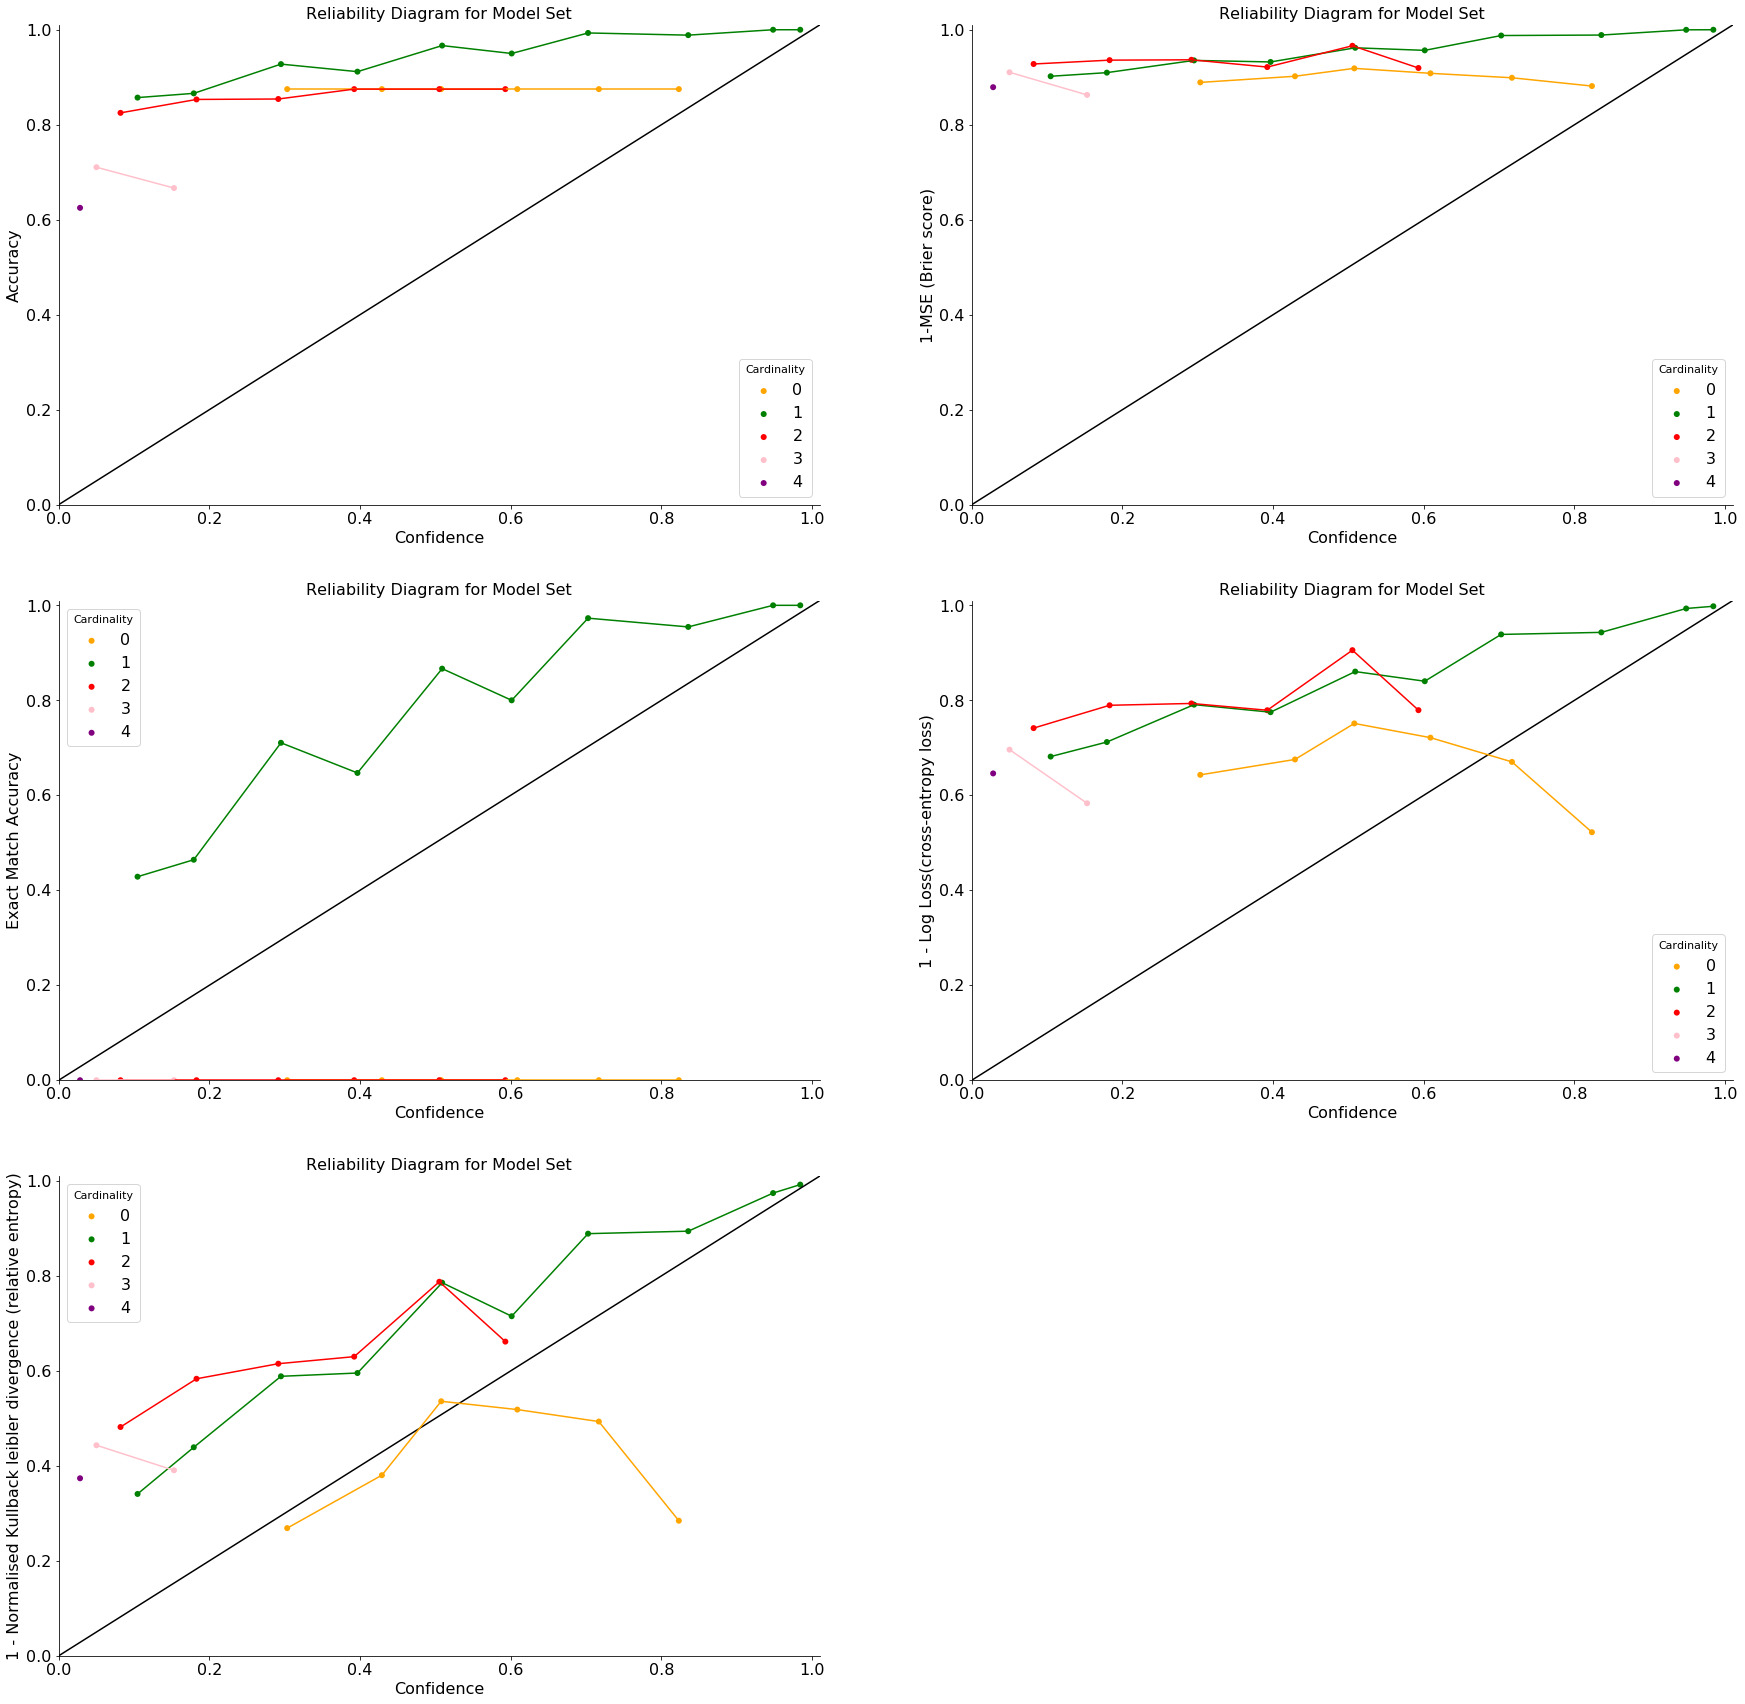

https://bigdatascientistblog.wordpress.com/2017/09/11/a-simple-introduction-to-kullback-leibler-divergence-through-python-code/


In [210]:
#we need to create a new dataframe with one v
#global_pos_validation_df = global_pos_validation_df.drop(['MSE','MSE_accuracy','exact_match','accuracy','color','conf_bin','cardinality'],axis =1)
def generate_set_accuracy_scores (global_pos_validation_df, thresholds, num_conf_bins=100):
    y_actual_list = []
    y_predict_prob_list = []
    y_predict_list = []
    brier_score = []
    exact_match = []
    accuracy = []
    kl_divergance = []
    log_loss_list = []
    kullback_leibler_divergence = []
    def kl_norm(x):
        return  (2 * (  math.exp(x)/ ( math.exp(x)+1 ) ) ) - 1
       

    for conv in thresholds:
        y_actual_list.append(conv)
        y_predict_prob_list.append(conv+"_prob_1") #
        y_predict_list.append(conv+"_y_pred") 
    
    y_actual_df = global_pos_validation_df[y_actual_list]
    y_predict_prob_df = global_pos_validation_df[y_predict_prob_list]
    y_predict_df = global_pos_validation_df[y_predict_list]
    for row in range(y_actual_df.shape[0]):
        actual = []
        predict = []
        actual.append( np.array(y_actual_df.iloc[row]) )
        predict.append( np.array(y_predict_df.iloc[row]) )
        brier_score.append(brier_score_loss(y_actual_df.iloc[row] , y_predict_prob_df.iloc[row]))
        accuracy.append(accuracy_score( np.array(y_actual_df.iloc[row]), np.array(y_predict_df.iloc[row]) ))
        exact_match.append(accuracy_score( np.array(actual), np.array(predict)  ))
        log_loss_list.append(log_loss( y_actual_df.iloc[row] , y_predict_prob_df.iloc[row], normalize=True, eps = 1e-7 ))
        kullback_leibler_divergence.append(kl_norm (stats.entropy(y_actual_df.iloc[row], y_predict_prob_df.iloc[row])))
       
    global_pos_validation_df["MSE"] = brier_score
    global_pos_validation_df["MSE_accuracy"] = 1 - global_pos_validation_df["MSE"]
    global_pos_validation_df["exact_match"] = exact_match
    global_pos_validation_df["accuracy"] = accuracy
    global_pos_validation_df["log_loss"] = log_loss_list
    global_pos_validation_df["log_loss_accu"] = 1 - global_pos_validation_df["log_loss"]
    global_pos_validation_df["kl_diverge"] = kullback_leibler_divergence
    global_pos_validation_df["kl_diverge_accu"] = 1 - global_pos_validation_df["kl_diverge"]
    #assigns a color to each lbl_cnt
    colors = ['orange', 'green',  'red','pink', 'purple', 'blue', 'brown', 'black', 'yellow']
    cardinality = []
    for x in range(global_pos_validation_df.shape[0]):
        cardinality.append (global_pos_validation_df.iloc[x].lbl_cnt)
    global_pos_validation_df['cardinality'] = cardinality


    color = []
    for x in range(global_pos_validation_df.shape[0]):
        y = global_pos_validation_df.iloc[x].cardinality
        color.append(colors[int(y)]) 
    global_pos_validation_df['color'] = color
    
    global_pos_validation_df['conf_bin'] = pd.qcut(global_pos_validation_df['set_conf'], q=num_conf_bins, duplicates='drop')
    return global_pos_validation_df


def plot_reliability(global_pos_validation_df):
    plt.clf()
    colors = {0:'orange', 1:'green',  2:'red',3:'pink', 4:'purple', 5:'blue', 6:'brown', 7:'black', 8:'yellow'}
    
    #group by confidence bin for the purpose of readability/standard format for reliability curve.
    binned_mean_df = global_pos_validation_df.groupby(['conf_bin', 'lbl_cnt']).mean()
    binned_mean_df = binned_mean_df.dropna().reset_index()
    color_list = []
    for x in range(binned_mean_df.shape[0]):
        y = binned_mean_df.iloc[x].cardinality
        color_list.append(colors[int(y)])     
    binned_mean_df['color'] = color_list
    binned_mean_df = binned_mean_df[['set_conf', 'MSE', 'MSE_accuracy', 'exact_match', 'accuracy','log_loss', 'log_loss_accu', 'kl_diverge','kl_diverge_accu', 'cardinality', 'color','conf_bin']].dropna()
    ###########
    
    
    plt.figure(figsize=(30,30))
    ax1 = plt.subplot(3, 2, 1)
    ax2 = plt.subplot(3, 2, 2)
    ax3 = plt.subplot(3, 2, 3)
    ax4 = plt.subplot(3, 2, 4)
    ax5 = plt.subplot(3, 2, 5)

    def my_sub_funct (ax, df, metric, ylabel, plot_line = False):
        #force it to start at 0 to 1
        ax.set_ylim(ymin=0, ymax=1.01)
        ax.set_xlim(xmin=0, xmax=1.01)
        #removing top and right borders
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        #draw the "unskilled" line
        line = mlines.Line2D([0, 1], [0, 1], color='black')
        transform = ax.transAxes
        line.set_transform(transform)
        ax.add_line(line)
        # Add title and axis names
        ax.set_title('Reliability Diagram for Model Set')
        ax.set_xlabel('Confidence')
        ax.set_ylabel(ylabel)

        #global_pos_validation_df.plot.scatter(ax = ax, x = 'set_conf', y = 'accuracy', s=None, c=list(global_pos_validation_df['color']), label = label, figsize=(10,10))
        for i, dff in df.groupby("cardinality"):
            ax.scatter( dff['set_conf'], dff[metric], s=None, c=dff['color'], 
                        edgecolors='none', label="{}".format(int(i)))
            ax.legend(title = "Cardinality")
            if plot_line == True:
                ax.plot( dff['set_conf'], dff[metric], c=colors[i])
        if plot_line == True:
            handles, labels = ax.get_legend_handles_labels()
            cut_by = len(handles)/2
            ax.legend(handles[int(cut_by):], labels[int(cut_by):], title = "Cardinality")
       #######################  
    
    
    
    my_sub_funct (ax1, binned_mean_df, "accuracy", "Accuracy", plot_line = True )
    my_sub_funct (ax2, binned_mean_df, "MSE_accuracy", "1-MSE (Brier score)", plot_line = True )
    my_sub_funct (ax3, binned_mean_df, "exact_match", "Exact Match Accuracy", plot_line = True )
    my_sub_funct (ax4, binned_mean_df, "log_loss_accu", "1 - Log Loss(cross-entropy loss)", plot_line = True)
    my_sub_funct (ax5, binned_mean_df, "kl_diverge_accu", "1 - Normalised Kullback leibler divergence (relative entropy)", plot_line = True )
    
    plt.show()
    print ("https://bigdatascientistblog.wordpress.com/2017/09/11/a-simple-introduction-to-kullback-leibler-divergence-through-python-code/")
    gc.collect()
    

plot_reliability(generate_set_accuracy_scores (global_final_results_df, global_final_threshold, 10))

#In the reliability diagram note that, predictions above the diagonal are under-confident and those below the diagonal are over-confident.
Both set cardinality and prior probability are features defined on the whole
label set, rather than individual labels. Such features capture constraints and
dependencies among labels, which were not originally considered by BR. Therefore these features 
supplement BR’s own prediction score and allow the calibrator to
make better overall judgments on the predicted set. the result will basically be a beter calibrated confidence score.


Each BR set prediction is transformed to a feature vector containing: 
- Original BR confidence score: 
- set cardinality, 
- set prior probability,
- set binary representation

and the binary correctness of the prediction is used as the regression target

In [ ]:

y_actual_list = []
for conv in global_final_threshold:
        y_actual_list.append(conv)
y_actual_list.append ('set_conf')
y_actual_list.append ('cardinality')
print (y_actual_list)


In [ ]:
to_calibrate_x = global_final_results_df[ y_actual_list ]
to_calibrate_y_actual = global_final_results_df[['exact_match']]


In [ ]:
from sklearn.utils import shuffle
from sklearn import ensemble
from sklearn.metrics import mean_squared_error

X, y = shuffle(to_calibrate_x, to_calibrate_y_actual, random_state=13)
X = X.astype(np.float32)
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset].copy(), y[:offset].copy()
X_test, y_test = X[offset:].copy(), y[offset:].copy()

# #############################################################################
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X_train, y_train['exact_match'])
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)
X_test['calibrated_conf'] = list(clf.predict(X_test))
display (X_test.head())
display (y_test.head())
display (X_test.shape[0])


display(to_calibrate_x.head(2))
display(to_calibrate_y_actual.head(2))
newly_calibrated = clf.predict(to_calibrate_x)
new_df = global_final_results_df.copy()
new_df = new_df.drop('set_conf', axis =1)
new_df ['set_conf'] = list(newly_calibrated)
display (new_df.head())
plot_reliability(new_df)
new_df = 0

# Evaluation Metrics for over all asystem (I need to modify this)
In multi-label classification, a misclassification is no longer a hard wrong or right. 
A prediction containing a subset of the actual classes should be considered 
better than a prediction that contains none of them, i.e., predicting two 
of the three labels correctly is better than predicting no labels at all. The following metrics can be used
   * Micro-averaging & Macro-averaging (Label based measures):
   * Hamming-Loss (Example based measure):
   * Exact Match Ratio (Subset accuracy):
   * Mean column-wise ROC AUC (average of the individual AUCs of each predicted column)


In [ ]:
numbers = [dict_roc_auc[key] for key in dict_roc_auc]
mean_auc = statistics.mean(numbers)
numbers = [dict_log_loss[key] for key in dict_log_loss]
mean_log_loss = statistics.mean(numbers)
print ("* Mean column-wise ROC AUC for set of models ", mean_auc)
print ("* Mean Log Loss for set of models", mean_log_loss )
print ("")
print ("* Macro average precision", "TBD" )
print ("* Macro average recall", "TBD" )
print ("* Macro average F1", "TBD" )
micro_average_max = pd.DataFrame(threshold_best_all.iloc[threshold_best_all.shape[0]-1])
micro_average = pd.DataFrame(threshold_t_calab_all.iloc[threshold_t_calab_all.shape[0]-1])
print ("")
print ("Micro averages using T-calab with metric")
display (micro_average)
print ("")
print ("Micro averages using max value of metric")
display (micro_average_max)


In [ ]:
display_validation_data(process_validation_data_for_stats(_DLModels, _DLData_val_x_txt_seq, _DLData_val_x_txt, _DLData_val_y ))


# Analyzing the Github and Semantic Scholar data

In [200]:
# This method will use the trained classification and calibration models to predict and quantify 
# the presence of conventions in new data(the data to be analyzed)
 
def predict_scores_and_classify(thresholds_in, to_predict_df, _tokenizer, _DLModels, _DLModelsIsotonicRegression, seq_len):
    
    predict = True
     
   
    if _tokenizer == None:
        f = open( 'extended_tokenizer.obj', 'rb') 
        extended_tokenizer = pickle.load(f)
        f.close()
    else:
        extended_tokenizer = _tokenizer
        
    sequences = extended_tokenizer.texts_to_sequences(to_predict_df['text'])
    data = pad_sequences(sequences, maxlen= seq_len) 
    extended_tokenizer = 0
    sequences = 0
    gc.collect()
    
    thresholds = {'civic': 0.5,
                  'domestic': 0.5,
                  'green': 0.5,
                  'industrial': 0.5,
                  'inspired': 0.5,
                  'market': 0.5,
                  'project': 0.5,
                  'renown': 0.5}
    # otherwise use default.
    
    if thresholds_in != None:
        thresholds = thresholds_in
       
    column_list = []
    column_list.append("repo_id")
    column_list.append("text")
    
    for conv in _DLModels.keys():
        column_list.append(conv)
        column_list.append(conv+"_prob")
        column_list.append(conv+"_y_pred")
        column_list.append(conv+"_prob_1")
        
    df = pd.DataFrame(columns=column_list)
    all_df = pd.DataFrame(columns=column_list)
    
    ###################
    #a sub function within the function, just used in this scope 
    def sub_funct_get_prob(prob, y):
        res = []
        for (probability, predicted) in zip(prob, y):
            if predicted == 1:
                res.append(probability)
            if predicted == 0:
                res.append(1 - probability)
        return res
    ####################

    df = pd.DataFrame(columns=column_list)
    
    #get the the txt of the sentence to be Analyzed
    df['text'] = to_predict_df["text"]
    df['repo_id'] = to_predict_df["repo_id"]

        

    for model in _DLModels.keys():
        my_model = _DLModels[model]           
        #First through the model
        y_predict = my_model.predict(data)
                
        #get the score for value = 1 as the response is [x,y] we need only the y values
        y_pos_predict_prob = get_positive_preds_probabilities(y_predict)
                
        #get the 1 or 0 value depending on the threshold
        y_pred = get_positive_preds_with_threshold(y_pos_predict_prob, thresholds[model])
                
        #if the call has been made with an isotonic reg calibration model too then call its predict.
        if _DLModelsIsotonicRegression != None:
            other_ir = _DLModelsIsotonicRegression[model]
            y_pos_predict_isotonic_prob = other_ir.predict(y_pos_predict_prob)
            y_pred = get_positive_preds_with_threshold(y_pos_predict_isotonic_prob, thresholds[model])
            y_pos_predict_prob = y_pos_predict_isotonic_prob
                
        #The probability of the y_predict, whether it i 1 or 0
        df[model+"_prob"] =  sub_funct_get_prob(y_pos_predict_prob, y_pred)
        df[model+"_y_pred"] = y_pred
        df[model+"_prob_1"] = y_pos_predict_prob         
        
   
    y_pred_list = []
    for x in df.columns.values:
        if x.endswith(('_y_pred')):
            y_pred_list.append(x)
            
    prob_list = []
    conv_list = []
    for x in df.columns.values:
        if x.endswith(('_prob')):
            prob_list.append(x)
            conv_list.append(x.replace('_prob', ''))
    
    if predict == True:
        #add the label cardinality as the sum of all the predicted = 1 for sentence for conventions
        pred_sums = df[y_pred_list].sum(axis=1)
        df['lbl_cnt'] = pred_sums
    
        #add the overall score as the product of all the individual predicted convention scores
        prob_product= all_df[prob_list].prod(axis=1)
        df['set_conf'] = prob_product
    
    
    #this will be > 1 if the same sentence was used as True for 2 or more conventions.
    positive_sample = df[conv_list].sum(axis=1)
    df['pos_sample'] = positive_sample
     
    print ("Num Dupes:", len(df.index) - len(df['text'].unique()) )
    print ("Dropping duplicate rows (these may be duplicate 0's due to training data construction)")
    df = df.drop_duplicates(keep = "first")
    
    co_occur_list = []
    rename = []
    for x in df.columns.values:
            if x.endswith(('_y_pred')):
                co_occur_list.append(x)
                rename.append(x.replace('_y_pred', ''))

    co_occur_y_predict = df[co_occur_list].copy()
    for old, x in zip(co_occur_list, range(len(co_occur_list))): 
        co_occur_y_predict = co_occur_y_predict.rename(columns={old: rename[x]})
        
    plt.figure(figsize=(10,5))
    plt.style.use('seaborn-dark-palette')
        
    text = "Predicted Co-occurance Matrix with Predicted and Actual Cardinality "
    display (HTML("<font color = green><h3><left>" + text + "</left></h3></font>"))
    ax1 = plt.subplot(1, 2, 1)
    ax1 = model_helpers.co_occurance_matrix (co_occur_y_predict)

    ax2 = plt.subplot(1, 2, 2)
    ax2 = model_helpers.label_cardinality_bar(co_occur_y_predict, title = "Predicted Cardinality") 
    plt.show()   
    return df.fillna(0), thresholds




def clean_description (text):
    #remove html markup
    text = re.sub("(<.*?>)","",text)
    text = re.sub("[\|\[].*?[\|\]]", "", text)
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text, flags=re.MULTILINE)
    text = text.replace("-", " ")# Added by Aideen
    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
                    
    text = html.unescape(text)# Added by Aideen remove the escape chars
    text = text.replace("\\n", "\n")# Added by Aideen
    text = text.replace("\n", " ")# Added by Aideen
    # Remove all the special characters except spaces, dashes, commas and dots
    text = re.sub(r'\. (?!\d)', '.\n ', str(text))
    text = re.sub(r"[^\s.,\-a-zA-Z0-9]", ' ', str(text))
    text = text.replace('\\xe\\x\\x', "'")## Added by Aideen\xe\x\x
    # sent = sent.replace("\\n", "\n")# Added by Aideen
    text = aivm_helper.pre_process_sentence(text)
    text = re.sub(r'^b\s+', '', str(text))
    text = text.replace(".\n.\n", ".\n")
    text = text.replace(". ", ".")
    text = text.replace("xef", "")
    text = text.replace("xbb", "")
    text = text.replace("xbf", "")
    return text


def create_pd_from_repo(AI_texts, AI_repo_id ):
    # for every repo in the AI_texts file, 
    # get the raw description
    # process it
    # convert to an array of sentences
    # add each individual sentence to a pandas
    # add the repo ID to the pandas.  in the end we will 
    # have a pandas DB with repo_id and text to be predicted.
    # only add the text if it is more than 40 letters long
    print ("num AI repos", len ( AI_texts))
    
    df_all = pd.DataFrame()
    for x in range(len(AI_texts)):
        df = pd.DataFrame()
        sent = AI_texts[x]
        repo_id = AI_repo_id[x]
        
        sen_arr = clean_description(sent).split("\n")
        
        df['text'] = sen_arr
        df['repo_id'] = repo_id
        df=df[df.text.apply(lambda x: len(str(x))>50)]
        df_all = pd.concat([df_all, df])
    print ("full list length",df_all.shape[0] )
    return df_all

def analyze_repo(url):
    AI_repos = pd.read_csv(url, sep=";")
    AI_texts = AI_repos['repo_raw_description'].values
    AI_repo_id = AI_repos['repo_id'].values
    AI_repos = 0
    gc.collect()
    res, _ = predict_scores_and_classify(global_final_threshold, create_pd_from_repo(AI_texts,AI_repo_id ), None, _DLModels, _DLModelsIsotonicRegression, model_helpers.MAX_SEQUENCE_LENGTH)
    display(res.head(10))
    AI_repos = 0
    AI_texts = 0
    AI_repo_id = 0

    text = "Probabilistic count v's Classification count"
    display (HTML("<font color = green><h4><left>" + text + "</left></h4></font>"))
    display (get_count(res, _DLModels, global_final_threshold, num_prob_buckets = 8, actual=False ))

num AI repos 8609
full list length 132325
Num Dupes: 5561
Dropping duplicate rows (these may be duplicate 0's due to training data construction)


,civic,domestic,green,industrial,inspired,market,project,renown
civic,725.0,170.0,24.0,88.0,28.0,156.0,221.0,126.0
domestic,170.0,3874.0,6.0,1526.0,454.0,920.0,1343.0,362.0
green,24.0,6.0,1433.0,347.0,10.0,78.0,32.0,46.0
industrial,88.0,1526.0,347.0,84961.0,3823.0,5263.0,4602.0,408.0
inspired,28.0,454.0,10.0,3823.0,6261.0,224.0,339.0,287.0
market,156.0,920.0,78.0,5263.0,224.0,10725.0,1103.0,325.0
project,221.0,1343.0,32.0,4602.0,339.0,1103.0,8894.0,354.0
renown,126.0,362.0,46.0,408.0,287.0,325.0,354.0,2254.0


,civic,domestic,green,industrial,inspired,market,project,renown
civic,1.00,0.04,0.01,0.00,0.00,0.01,0.02,0.04
domestic,0.04,1.00,0.00,0.02,0.04,0.06,0.11,0.06
green,0.01,0.00,1.00,0.00,0.00,0.01,0.00,0.01
industrial,0.00,0.02,0.00,1.00,0.04,0.06,0.05,0.00
inspired,0.00,0.04,0.00,0.04,1.00,0.01,0.02,0.03
market,0.01,0.06,0.01,0.06,0.01,1.00,0.06,0.03
project,0.02,0.11,0.00,0.05,0.02,0.06,1.00,0.03
renown,0.04,0.06,0.01,0.00,0.03,0.03,0.03,1.00


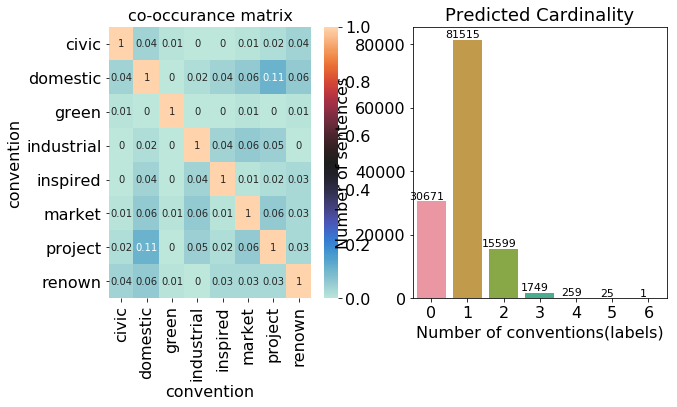

,repo_id,text,civic,civic_prob,civic_y_pred,civic_prob_1,domestic,domestic_prob,domestic_y_pred,domestic_prob_1,...,project_prob,project_y_pred,project_prob_1,renown,renown_prob,renown_y_pred,renown_prob_1,lbl_cnt,set_conf,pos_sample
0,45717250,is an end to end open source platform for mach...,0,0.989305,0,0.010695,0,0.986486,0,0.013514,...,0.780488,0,0.219512,0,0.987179,0,0.012821,1,0.0,0.0
1,45717250,it has a comprehensive flexible ecosystem of ...,0,0.989305,0,0.010695,0,1.000000,0,0.000000,...,0.979592,0,0.020408,0,0.992063,0,0.007937,0,0.0,0.0
2,45717250,tensorflow was originally developed by resear...,0,0.989305,0,0.010695,0,1.000000,0,0.000000,...,0.880000,0,0.120000,0,0.987179,0,0.012821,0,0.0,0.0
3,45717250,the system is general enough to be applicable...,0,0.966667,0,0.033333,0,1.000000,0,0.000000,...,0.880000,0,0.120000,0,0.939024,0,0.060976,1,0.0,0.0
4,45717250,tensorflow provides stable apis as well as no...,0,0.966667,0,0.033333,0,1.000000,0,0.000000,...,0.993007,0,0.006993,0,1.000000,0,0.000000,1,0.0,0.0
5,45717250,see all the install see the for the to use a ...,0,0.932203,0,0.067797,0,0.986486,0,0.013514,...,0.880000,0,0.120000,0,0.969072,0,0.030928,0,0.0,0.0
6,45717250,this project adheres to tensorflow is code of...,0,0.989305,0,0.010695,0,0.961538,0,0.038462,...,0.471698,1,0.471698,0,0.969072,0,0.030928,2,0.0,0.0
7,45717250,by participating you are expected to uphold t...,0,0.989305,0,0.010695,0,0.986486,0,0.013514,...,0.979592,0,0.020408,0,1.000000,0,0.000000,1,0.0,0.0
0,33015583,keras deep learning for humans you have jus...,0,0.990991,0,0.009009,0,0.823529,0,0.176471,...,0.461538,1,0.461538,0,0.992063,0,0.007937,1,0.0,0.0
1,33015583,keras is a high level neural networks api wri...,0,0.989305,0,0.010695,0,0.986486,0,0.013514,...,0.979592,0,0.020408,0,0.987179,0,0.012821,0,0.0,0.0


,Convention,Calibrated Prob count,Classifier count,Threshold,True count
0,civic,9125,725,0.2,not applicable
1,domestic,8413,3874,0.2,not applicable
2,green,8763,1433,0.5,not applicable
3,industrial,65002,84961,0.4,not applicable
4,inspired,7868,6261,0.3,not applicable
5,market,12312,10725,0.2,not applicable
6,project,13482,8894,0.3,not applicable
7,renown,8344,2254,0.2,not applicable


<Figure size 432x288 with 0 Axes>

In [201]:
analyze_repo("Data/ToBeAnalyzed/github_AI_repos_dump.csv")

In [ ]:
analyze_repo("Data/ToBeAnalyzed/github_non_AI_repos_dump.csv")

# TO BE REVIEWED BELOW HERE

In [ ]:
#AF: not sure what is the purpose of this, ie why are we training the models again?
def train_models_and_get_scores(df, t_calibration, N_executions=1):
    accs = {}
    precs = {}
    AUCs = {}
    for i in tqdm.tqdm(range(N_executions)):
    
        _DLModels, _DLTokenizers, _DLData_val_x, _DLData_val_y, _DLTrain_histories = model_helpers.train_DL_models(df,
                    data_class_column="convention", 
                    data_label_column="label",
                    tokenizer=extended_tokenizer,
                    random_seed=0,
                    use_validation=True) 

        for k in _DLModels.keys():
            model = _DLModels[k]
            x_val = _DLData_val_x[k]
            y_val = _DLData_val_y[k][:,1]

            pred = model.predict(x_val)[:,1]
            y_pred = apply_pred_threshold(pred, t_calibration)



            if k in accs:
                accs[k].append(accuracy_score(y_val, y_pred))
                precs[k].append(precision_score(y_val, y_pred))
                AUCs[k].append(roc_auc_score(y_val, y_pred))
            else:
                accs[k] = [accuracy_score(y_val, y_pred)]
                precs[k] = [precision_score(y_val, y_pred)]
                AUCs[k] = [roc_auc_score(y_val, y_pred)]
        
    return accs, precs, AUCs

#AF: not sure what is the purpose of this, ie why are we training the models again? commenting out for now:

# accs, precs, AUCs = train_models_and_get_scores(training_df, equalized_precisions_threshold)
# print("Models performance on unseen data:\n\n")
# custom_ordered_keys = ["industrial", "project", "market", "inspired", "civic", "domestic", "green", "renown"]
# for k in custom_ordered_keys:
#     avg_acc = "%.3f" % np.mean(accs[k])
#     avg_auc = "%.3f" % np.mean(AUCs[k])
#     avg_prec = "%.3f" % np.mean(precs[k])
    
#     print("{} & {}  & {} & {}\\".format(k, avg_acc, avg_prec, avg_auc))
#     print("\hline")


#this method is called once per convention with the combined responses of all used as input to
#plot the confusion matrix. The difference between this method and the AF method is that here only 
#the validation data that has true label of 1 is being used, as opposed to blindly using the data and 
#plotting a confusion matrix of the predicted_y = 1. in other words this does not consider any entry 
#in the validation set where for example convention A gives a prediction of 1 when in reality the real label is 0.
#i think this may be a bug?
def compute_confusions(conv, models_, data_x, data_y, calibration_threshold=0.656):
    global classifier_thresholds
    #create a list with  a value for each convention(initially set to 0).
    matches = [0] * len(classifier_thresholds.keys())
 
    #for convention = conv we will get a list of sentences from the validation data for ground truth label = True(1)
    sentences = data_x[conv][np.argwhere(data_y[conv][:,1]==1)]
    shape = sentences.shape
    sentences = sentences.reshape(shape[0], shape[2])
    sent_length = len(sentences)
    
    #iterate through conventions and a value between 0 and len(list "matches")
    for k, idx in zip(classifier_thresholds.keys(), range(len(matches))):
        print(sentences.shape)
        pred = models_[k].predict(sentences, verbose=0)
        pred = np.array(pred)
        matches[idx] = (pred[pred[:,1]> classifier_thresholds[k]]).sum()
    
        
    return matches, sent_length

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          class_lengths = None):
    
    #print(cm)
    if normalize:
        if class_lengths:
            cm = cm.astype('float') / np.array(class_lengths)[:, np.newaxis]
        else:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
    print(np.sum(cm[:,1]))
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix \n Accuracy: "%.5f"' % np.mean(cm.diagonal()) 
        else:
            title = 'Confusion matrix, without normalization \n Accuracy: "%.5f"' % np.mean(cm.diagonal()) 
            
    classes = [c.capitalize() for c in classes]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    ax.set_ylim(cm.shape[0]-0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    
    #thresh = 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    #color=cm[i,j])
                    color="white" if cm[i, j] > thresh else "black")
    
    #fig.tight_layout()
    return ax
y_true = []
y_pred = []

conf_matrix = []
class_lengths = []


for conv in classifier_thresholds.keys():
    print(" -- {}     ".format(conv))
    matches, cl_len = compute_confusions(conv, _DLModels, _DLData_val_x, _DLData_val_y)
    conf_matrix.append(matches)
    class_lengths.append(cl_len)
    
conf_matrix = np.array(conf_matrix)
class_names = list(classifier_thresholds.keys())
print (class_names)
plot_confusion_matrix(conf_matrix, class_names, normalize=True, class_lengths = class_lengths)
display(conf_matrix)

## Matches histograms

In [ ]:
def plot_matches_histogram_multiclass(_matches, _models, title=None, data_sources=[]):

    f, ax = plt.subplots(figsize=[12,6])
    
    elems = [k.replace("training_", "").replace(".txt", "").capitalize()  for k in list(_models.keys())]

    
    barWidth = 0.25  # the width of the bars
    # Set position of bar on X axis
    r1 = np.arange(len(elems))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    
    rs = [r1,r2,r3]


    
    for m_idx, m in enumerate(_matches):
        f = np.array(m).sum(axis=0)
        f = f / np.sum(f)
        
        print(f)
        print(r1)

        plt.bar(rs[m_idx], f, width=barWidth, edgecolor='white', label=data_sources[m_idx])
        
    # Add xticks on the middle of the group bars
    plt.xlabel('Conventions', fontweight='bold')
    plt.ylabel('Percentage', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(elems))], elems)
    plt.legend()
    plt.show()

def get_model_matches(sequences, model):
    #this is called once per model per description
    #tf.keras.preprocessing.sequence.pad_sequences
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    preds = model.predict(data)

    return preds

def count_positive_preds(preds):
    count = 0
    for j in range(len(preds)):
    
        count += int(preds[j][1]>preds[j][0])
    return count

def count_positive_preds_with_threshold(preds, threshold=0.5):
    count = 0
    for j in range(len(preds)):
    
        count += int(preds[j][1]>=threshold)
    return count

def calculate_matches(repositories_descriptions, _models, _tokenizers, model_preds_func=count_positive_preds, threshold=None):
    _repos_matches = []
    

    ##Â Counting number of matches per model for each repo
    for r_description in repositories_descriptions:
        #here we are generating a list of sentences
        r_description = r_description.split("\n")
        
        this_repo_matches = []
        for model_key in _models.keys():
            #now for every model, tokenize the sentence(tokenizers are the same? so no need to repeat.)
            matches=0

            tokenized_r_description = _tokenizers[model_key].texts_to_sequences(r_description)
            
            #pads the data and calls the predict function of the model in question(model_key)
            preds = get_model_matches(tokenized_r_description, _models[model_key])

            if threshold is None:
                num_matches = model_preds_func(preds)
            else:
                #call the "count_positive_preds_with_threshold" as this function was used as an input
                num_matches = model_preds_func(preds, threshold)

            this_repo_matches.append(num_matches)

        _repos_matches.append(this_repo_matches)
        
    return _repos_matches

In [ ]:
AI_repos = pd.read_csv("Data/ToBeAnalyzed/github_AI_repos_dump.csv", sep=";")
not_AI_repos = pd.read_csv("Data/ToBeAnalyzed/github_non_AI_repos_dump.csv")
display (not_AI_repos.head())
MAX_SEQUENCE_LENGTH=32


AI_texts = AI_repos['cleaned_descriptions'].values
#AI_texts =[t.split("\n") for t in AI_texts]
AI_repos_matches = calculate_matches(AI_texts, 
                                     models[0][0], 
                                    models[0][1],
                                    model_preds_func=count_positive_preds_with_threshold, 
                                    threshold = 0.656) ##As obtained above!


not_AI_texts = not_AI_repos['cleaned_descriptions'].values
not_AI_repos_matches = calculate_matches(not_AI_texts, 
                                     models[0][0], 
                                    models[0][1],
                                    model_preds_func=count_positive_preds_with_threshold, 
                                    threshold = 0.656) ##As obtained above!


S2_texts = []
with open("Data/ToBeAnalyzed/s2_random_3345_nn.txt", "rb") as f:
    S2_texts = f.readlines()
    f.close()
S2_texts = [str(s) for s in S2_texts]
    
S2_matches = calculate_matches(S2_texts, 
                                     models[0][0], 
                                    models[0][1],
                                    model_preds_func=count_positive_preds_with_threshold, 
                                    threshold = 0.656) ##As obtained above!

In [ ]:
data_sources = ['AI repositories', 'Not AI repositories', 'AI scientific articles']
plot_matches_histogram_multiclass([AI_repos_matches, not_AI_repos_matches, S2_matches], models[0][0], "Conventions for not AI research articles", data_sources)
print(len(AI_repos))
print(len(not_AI_repos))okay
ai_sents = []
for t in AI_repos['cleaned_descriptions'].values:
    for term in t.split("\n"):
        ai_sents.append(str(term))
display(len(ai_sents))


not_ai_sents = []
for t in not_AI_repos['cleaned_descriptions'].values:
    for term in t.split("\n"):
        not_ai_sents.append(str(term))
display (len(not_ai_sents))

display (AI_repos['repo_num_stars'].hist(bins=50))
display(np.mean(AI_repos['repo_num_stars']))
display(np.mean(not_AI_repos['repo_num_stars']))
display(np.max(AI_repos['repo_num_stars']))
display(np.mean(AI_repos['repo_num_stars']))
display(AI_repos.head())
display(AI_repos['repo_language'].mode())
display(not_AI_repos['repo_language'].mode())
display(len(AI_repos[AI_repos['repo_language'] == 'Python']) / len(AI_repos))
display(len(not_AI_repos[not_AI_repos['repo_language'] == 'JavaScript']) / len(not_AI_repos))

In [ ]:
training_df[training_df['convention'] == 'inspired']

In [ ]:
for c in training_df['convention'].unique():
    print(c)
    print(len(training_df[training_df['convention'] == c]))
    print()

In [ ]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


digits = load_digits()
X, y = digits.data, digits.target


title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
# Function to create model, required for KerasClassifier
def create_model(epochs=20):
    word_index = extended_tokenizer.word_index
    num_epochs = epochs
    EMBEDDING_DIM=100
    MAX_SEQUENCE_LENGTH=32
    
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)


    convs = []
    filter_sizes = [3,4,5]

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    for fsz in filter_sizes:
        l_conv = Conv1D(nb_filter=128,filter_length=fsz,activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(5)(l_conv)
        convs.append(l_pool)

    l_merge = Concatenate(axis=1)(convs)#

    l_cov1= Conv1D(128, 5, activation='relu')(l_merge)
    l_pool1 = MaxPooling1D(5)(l_cov1)

    l_flat = Flatten()(l_pool1)
    l_dense = Dense(128, activation='relu')(l_flat)
    preds = Dense(2, activation='softmax')(l_dense)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])
    return model
    
model = KerasClassifier(build_fn=create_model, epochs=20, verbose=0)

In [ ]:
np.linspace(.1, 1.0, 2)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
training_df['convention'].unique()

In [ ]:
for _conv in training_df['convention'].unique():
    tmp_df_train = training_df[training_df['convention']==_conv]

    texts = tmp_df_train['text'].values
    labels = tmp_df_train['label'].values

    sequences = extended_tokenizer.texts_to_sequences(texts)


    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

    labels = to_categorical(np.asarray(labels))

    X=data
    y=labels

    title = "Learning Curves ({})".format(_conv.capitalize())
    # Cross validation with 100 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

    estimator = KerasClassifier(build_fn=create_model, epochs=20, verbose=0)
    plot_learning_curve(estimator, title, X, y, ylim=(0.6, 1.01), cv=cv, n_jobs=4)

    plt.show()

In [ ]:
data_portions = np.arange(.1, 1.01, 0.10)
print(data_portions)

accs = []

for p in data_portions:
    
    tmp_df_train = training_df[training_df['convention']=='industrial']

    texts = tmp_df_train['text'].values
    labels = tmp_df_train['label'].values

    sequences = extended_tokenizer.texts_to_sequences(texts)


    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

    labels = to_categorical(np.asarray(labels))
    
    selected_indexes = random.choice(list(enumerate(X)))[0]
    
    tmp_x = data[selected_indexes]
    tmp_y = labels[selected_indexes]
    
    
    
    
    

    title = "Learning Curves (Industrial)"
    # Cross validation with 100 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    #cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

    estimator = KerasClassifier(build_fn=create_model, epochs=20, verbose=0)
    
    
    estimator.train(tmp_x)

    
    accs.append(metrics.accuracy_score())